In [1]:
import os

from autocvd import autocvd
autocvd(num_gpus = 2)
# os.environ['CUDA_VISIBLE_DEVICES'] = '4'  # Set the GPU to use, if available



import jax 
import jax.numpy as jnp
from jax import jit, random
import equinox as eqx
from jax.sharding import Mesh, PartitionSpec, NamedSharding
from jax.scipy.stats import gaussian_kde
# jax.config.update("jax_enable_x64", True)  # Enable 64-bit precision

import matplotlib.pyplot as plt


import numpy as np
from astropy import units as u
from astropy import constants as c

import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_LAXMAP, DIRECT_ACC_FOR_LOOP, DIRECT_ACC_MATRIX
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, PSPParams, MN_POTENTIAL, NFW_POTENTIAL, PSP_POTENTIAL
from odisseo.initial_condition import Plummer_sphere, ic_two_body, sample_position_on_sphere, inclined_circular_velocity, sample_position_on_circle, inclined_position
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot
from odisseo.potentials import MyamotoNagai, NFW

from odisseo.utils import halo_to_gd1_velocity_vmap, halo_to_gd1_vmap, projection_on_GD1


plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})



In [2]:
code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
G = 1
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1, unit_time = code_time )  
# code_units = CodeUnits(code_length, code_mass, G=G)  # default values


config = SimulationConfig(N_particles = 1000, 
                          return_snapshots = True, 
                          num_snapshots = 500, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (0.1 * u.pc).to(code_units.code_length).value,) #default values

params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.05 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 


key = random.PRNGKey(1)

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)


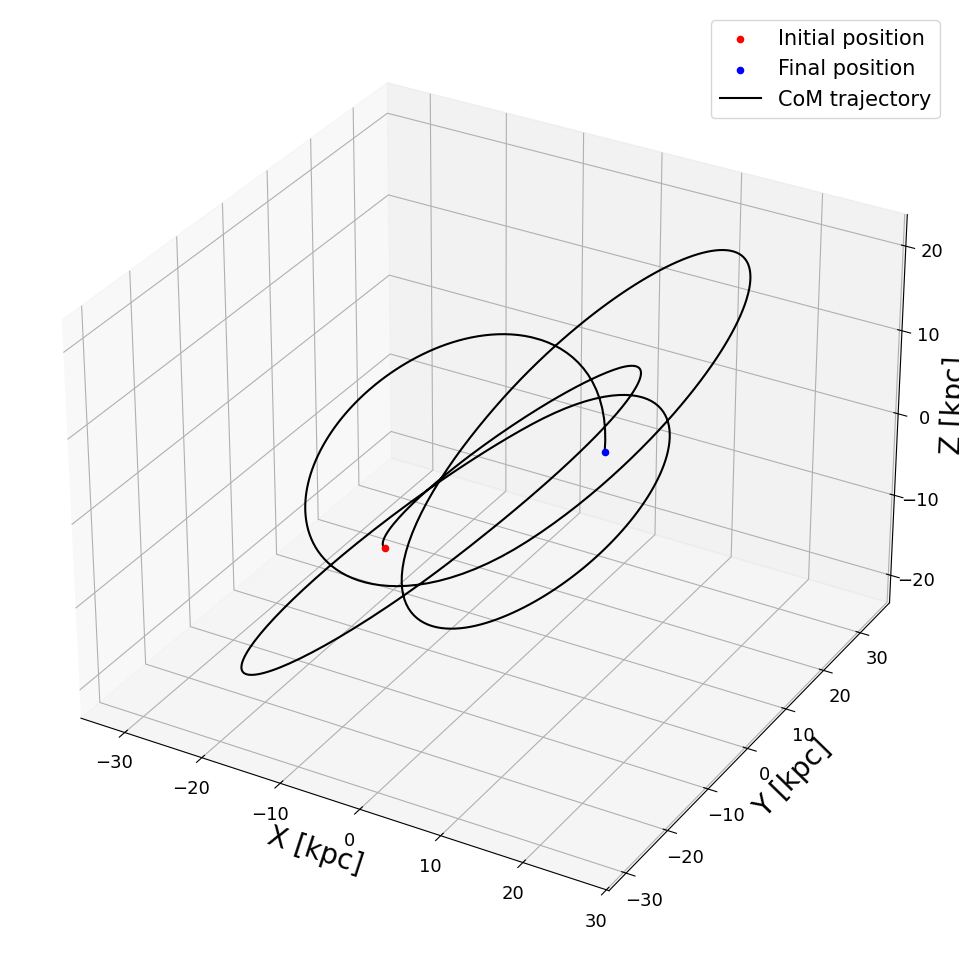

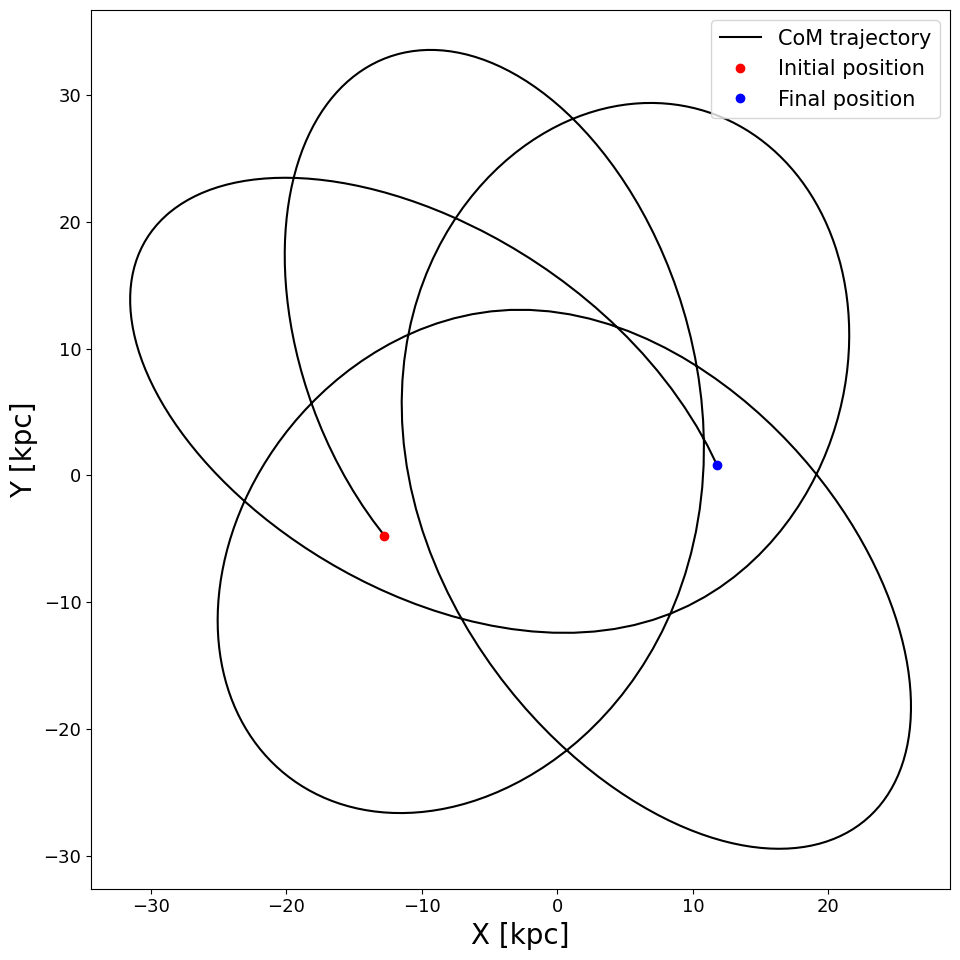

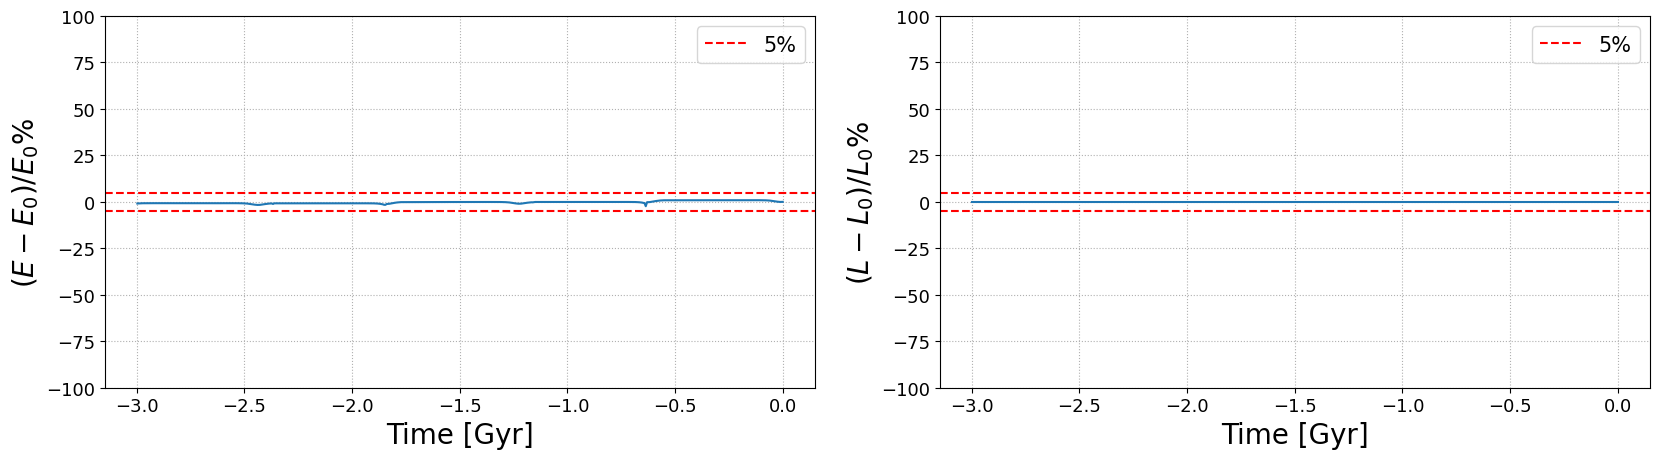

In [3]:
#the center of mass needs to be integrated backwards in time first 
config_com = config._replace(N_particles=1,return_snapshots=True,)
params_com = params._replace(t_end=-params.t_end,)

#this is the final position of the cluster, we need to integrate backwards in time 
pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
# pos_com_final = jnp.array([[12.4, 1.5, 7.1]]) * u.kpc.to(code_units.code_length)
# vel_com_final = jnp.array([[107.0, -243.0, -105.0]]) * (u.km/u.s).to(code_units.code_velocity)


mass_com = jnp.array([params_com.Plummer_params.Mtot])
final_state_com = construct_initial_state(pos_com_final, vel_com_final)

snapshots_com = time_integration(final_state_com, mass_com, config_com, params_com)
pos_com, vel_com = snapshots_com.states[-1, :, 0], snapshots_com.states[-1, :, 1]

##### CoM orbit plot####
fig = plt.figure(figsize=(15, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(snapshots_com.states[-1, 0, 0, 0]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[-1, 0, 0, 1]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[-1,0, 0, 2]* code_units.code_length.to(u.kpc),c='r', label='Initial position')
ax.scatter(snapshots_com.states[0, 0, 0, 0]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[0, 0, 0, 1]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[0,0, 0, 2]* code_units.code_length.to(u.kpc), c='b', label='Final position')
ax.plot(snapshots_com.states[:, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:, 0, 0, 1]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:,0, 0, 2]* code_units.code_length.to(u.kpc), 'k-', label='CoM trajectory')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.set_zlabel("Z [kpc]")
ax.legend()
plt.show()

fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111)
ax.plot(snapshots_com.states[:, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:, 0, 0, 1]* code_units.code_length.to(u.kpc), 'k-', label='CoM trajectory')
ax.plot(snapshots_com.states[-1, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[-1, 0, 0, 1]* code_units.code_length.to(u.kpc), 'ro', label='Initial position')
ax.plot(snapshots_com.states[0, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[0, 0, 0, 1]* code_units.code_length.to(u.kpc), 'bo', label='Final position')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.legend()

energy_angular_momentum_plot(snapshots_com, code_units,)

# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state_stream = construct_initial_state(positions, velocities)

In [4]:
#run the simulation
snapshots = time_integration(initial_state_stream, mass, config, params)

In [5]:
# mesh = Mesh(np.array(jax.devices()), ("i",))
# initial_state_sharded = jax.device_put(initial_state_stream, NamedSharding(mesh, PartitionSpec("i")))
# mass_sharded = jax.device_put(mass, NamedSharding(mesh, PartitionSpec("i")))
snapshots = time_integration(initial_state_stream, mass, config, params)

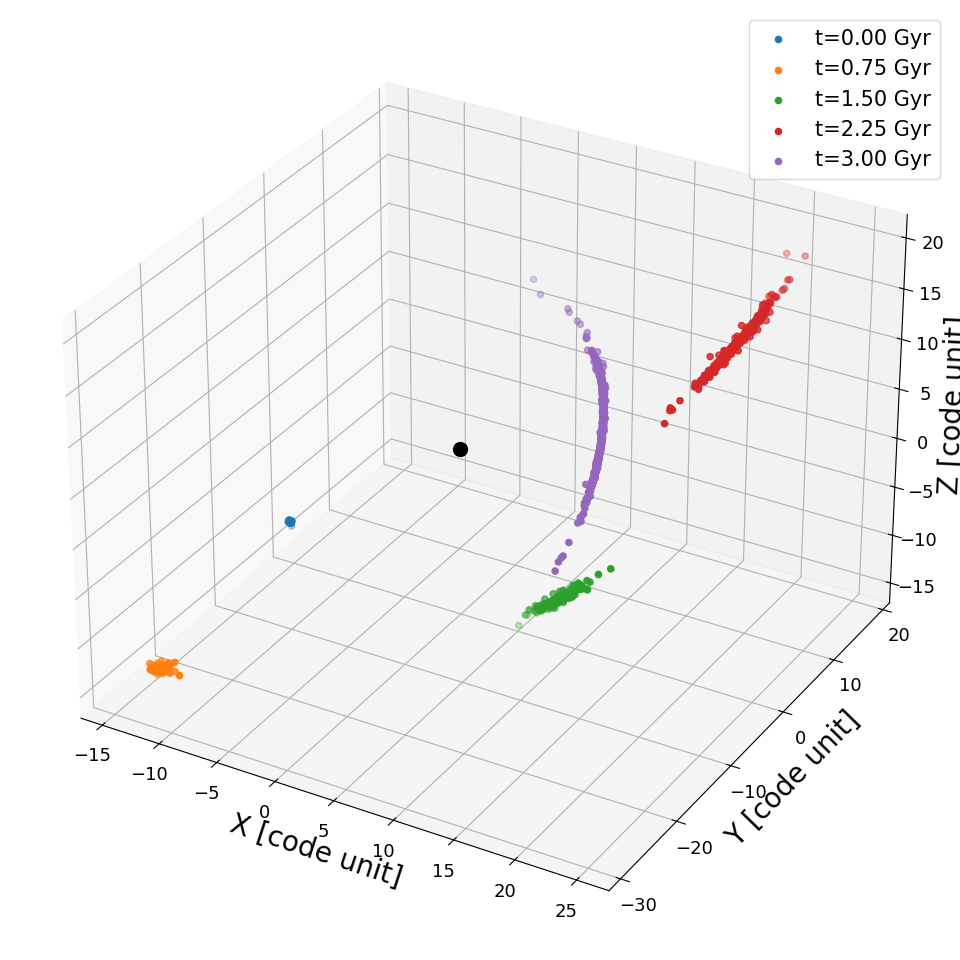

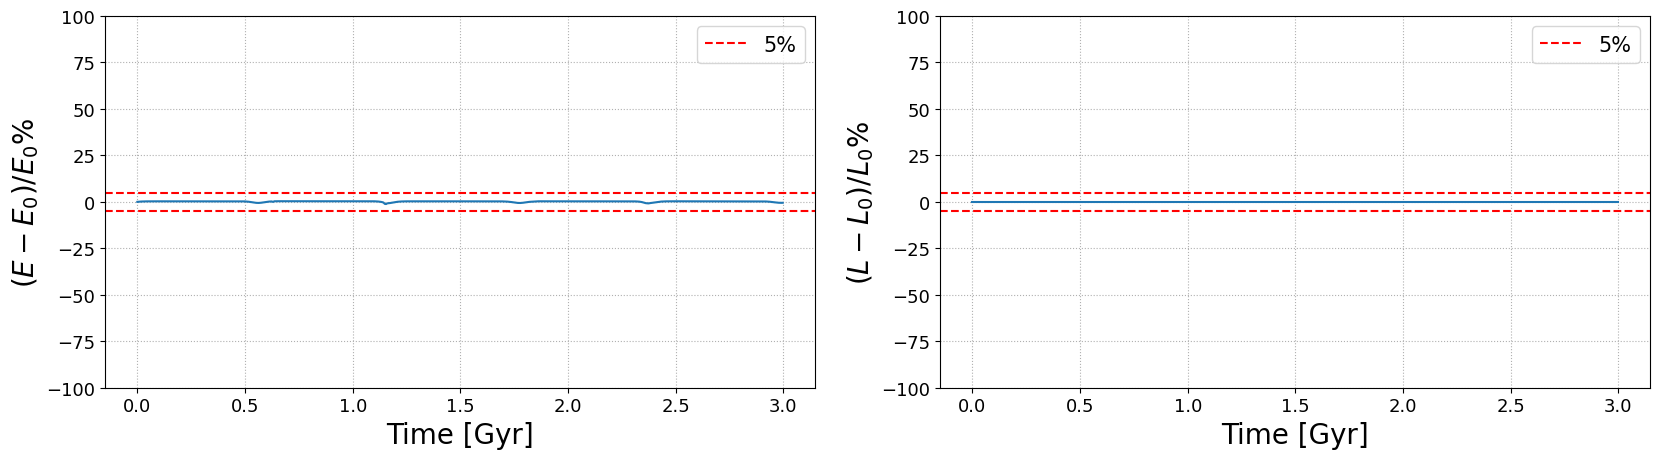

In [6]:
fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
for i in np.linspace(0, config.num_snapshots, 5, dtype=int):
    ax.scatter(snapshots.states[i, :, 0, 0] * code_units.code_length.to(u.kpc), 
               snapshots.states[i, :, 0, 1] * code_units.code_length.to(u.kpc), 
               snapshots.states[i, :, 0, 2] * code_units.code_length.to(u.kpc), label=f"t={(snapshots.times[i]*code_units.code_time).to(u.Gyr):.2f}")
ax.scatter(0, 0, 0, c='k', s=100, )
ax.set_xlabel('X [code unit]')
ax.set_ylabel('Y [code unit]')
ax.set_zlabel('Z [code unit]')
# ax.set_xlim(-30, 30)
# ax.set_ylim(-30, 30)
# ax.set_zlim(-30, 30)
ax.legend()


energy_angular_momentum_plot(snapshots, code_units,)


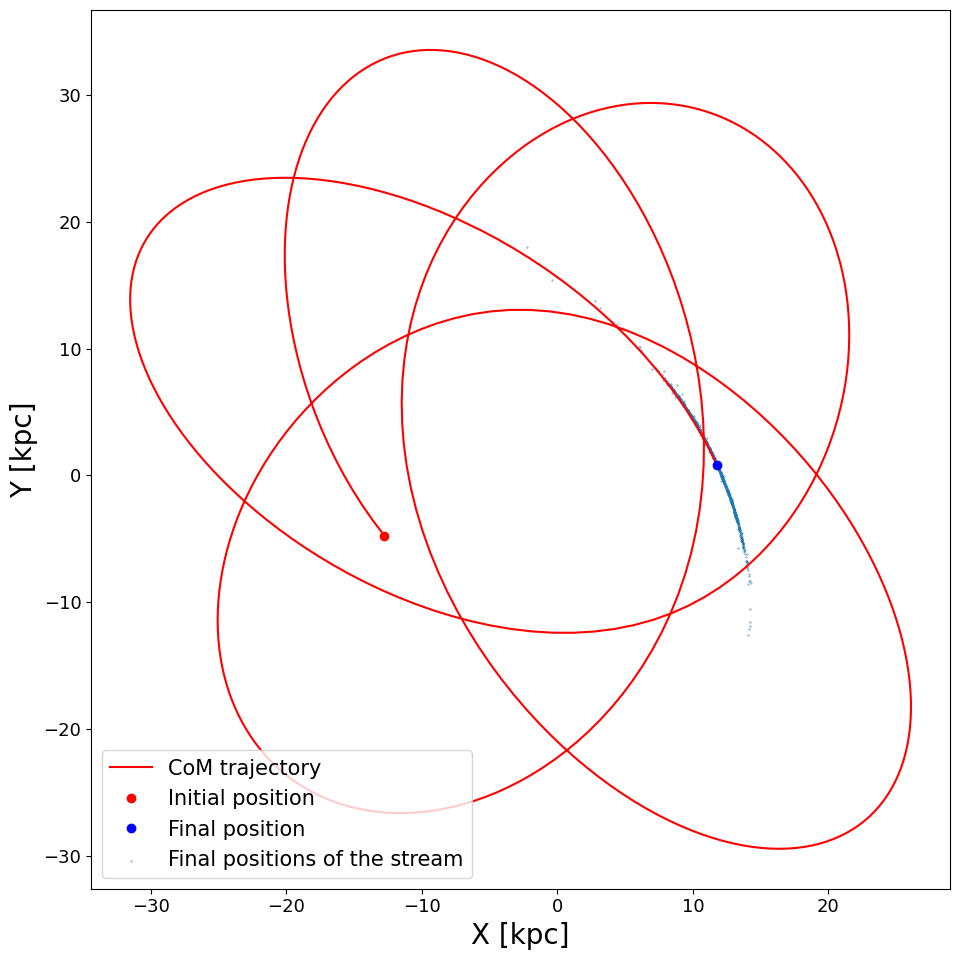

In [7]:
fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111)
ax.plot(snapshots_com.states[:, 0, 0, 0]* code_units.code_length.to(u.kpc), 
    snapshots_com.states[:, 0, 0, 1]* code_units.code_length.to(u.kpc), 'r-', label='CoM trajectory')
ax.plot(snapshots_com.states[-1, 0, 0, 0]* code_units.code_length.to(u.kpc), 
    snapshots_com.states[-1, 0, 0, 1]* code_units.code_length.to(u.kpc), 'ro', label='Initial position')
ax.plot(snapshots_com.states[0, 0, 0, 0]* code_units.code_length.to(u.kpc), 
    snapshots_com.states[0, 0, 0, 1]* code_units.code_length.to(u.kpc), 'bo', label='Final position')
ax.scatter(snapshots.states[-1, :, 0, 0]* code_units.code_length.to(u.kpc), 
    snapshots.states[-1, :, 0, 1]* code_units.code_length.to(u.kpc), s=0.1, label='Final positions of the stream')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
# ax.set_xlim(-30, 30)
# ax.set_ylim(-30, 30)
ax.legend()

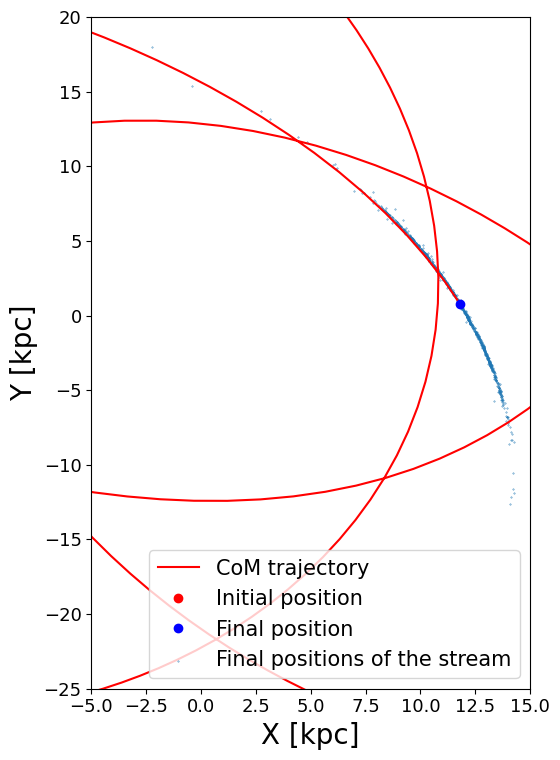

In [8]:
fig = plt.figure(figsize=(6, 8), tight_layout=True)
ax = fig.add_subplot(111)
conversion = code_units.code_length.to(u.kpc)
ax.plot(snapshots_com.states[:, 0, 0, 0]*conversion, 
        snapshots_com.states[:, 0, 0, 1]* conversion, 'r-', label='CoM trajectory')
ax.plot(snapshots_com.states[-1, 0, 0, 0]*conversion,
         snapshots_com.states[-1, 0, 0, 1]*conversion, 'ro', label='Initial position')
ax.plot(snapshots_com.states[0, 0, 0, 0]*conversion, 
        snapshots_com.states[0, 0, 0, 1]*conversion, 'bo', label='Final position')
ax.scatter(snapshots.states[-1, :, 0, 0]*conversion, 
           snapshots.states[-1, :, 0, 1]*conversion, s=0.1, label='Final positions of the stream')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.set_xlim(-5, 15)
ax.set_ylim(-25, 20)
ax.legend()

In [9]:
final_state = snapshots.states[-1].copy()
final_positions, final_velocities = final_state[:, 0], final_state[:, 1]

final_positions = final_positions * code_units.code_length.to(u.kpc)
final_velocities = final_velocities * code_units.code_velocity.to(u.kpc / u.Myr)

(-250.0, 250.0)

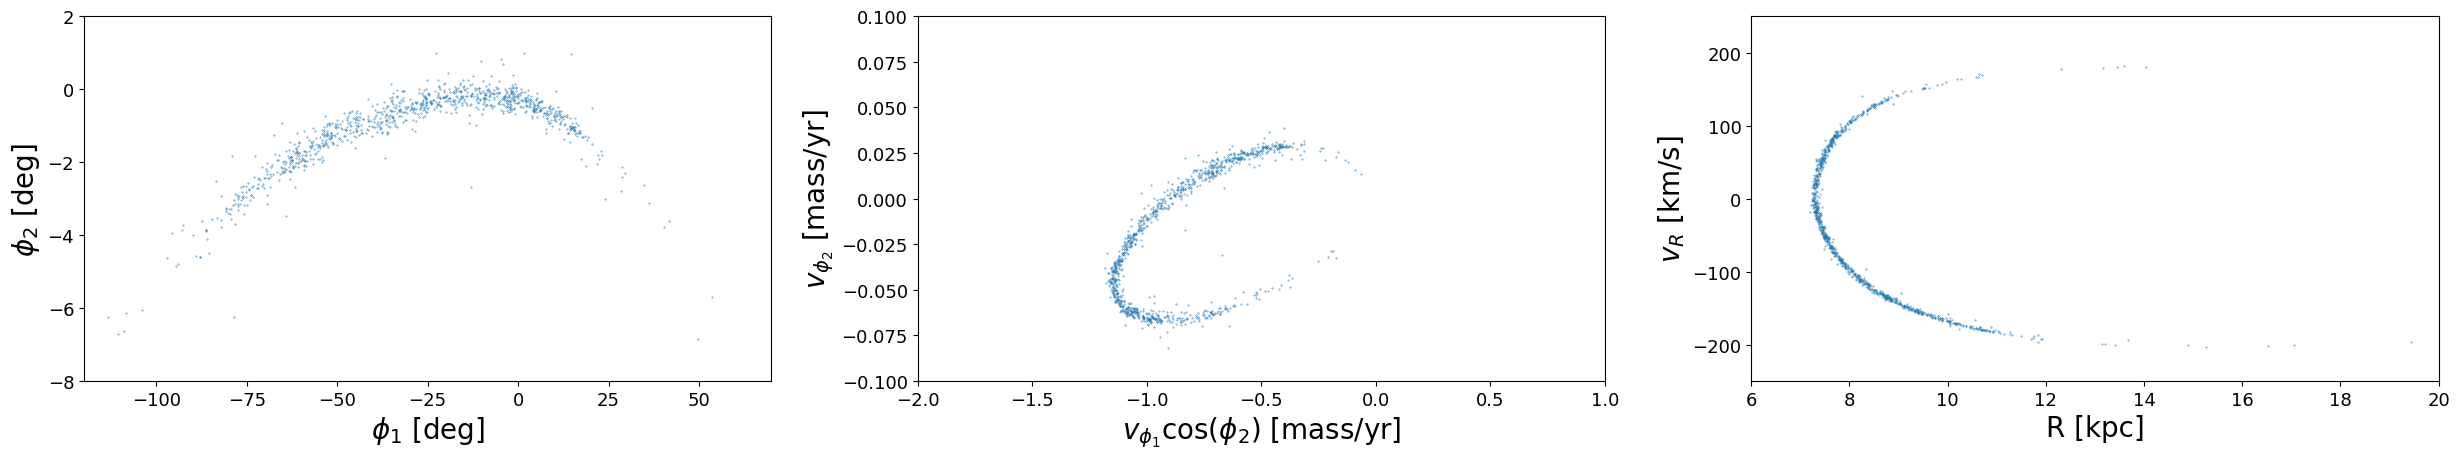

In [10]:
s = projection_on_GD1(final_state, code_units=code_units,)
R = s[:, 0]  # kpc
phi1 = s[:, 1]  # deg
phi2 = s[:, 2]  # deg
vR = s[:, 3]  # km/s
v1_cosphi2 = s[:, 4]  # mass/yr
v2 = s[:, 5]  # mass/yr

fig = plt.figure(figsize=(25, 5), tight_layout=True)

ax = fig.add_subplot(131)
ax.scatter(phi1, phi2, s=0.1)
ax.set_xlabel("$\phi_1$ [deg]")
ax.set_ylabel("$\phi_2$ [deg]")
ax.set_xlim(-120, 70)
ax.set_ylim(-8, 2)

ax = fig.add_subplot(132)
ax.scatter(v1_cosphi2 ,
           v2 ,
            s=0.1)
ax.set_xlabel("$v_{\phi_1}\cos(\phi_2)$ [mass/yr]")
ax.set_ylabel("$v_{\phi_2}$ [mass/yr]")
ax.set_xlim(-2., 1.0)
ax.set_ylim(-0.10, 0.10)

ax = fig.add_subplot(133)
ax.scatter(R, vR , s=0.1)
ax.set_xlabel("R [kpc]")
ax.set_ylabel("$v_R$ [km/s]")
ax.set_xlim(6, 20)
ax.set_ylim(-250, 250)


/tmp/ipykernel_3240670/3570116978.py:21: RuntimeWarning: divide by zero encountered in log10
  im1 = ax.pcolormesh(PHI1, PHI2, np.log10(counts1), cmap='coolwarm')
/tmp/ipykernel_3240670/3570116978.py:31: RuntimeWarning: divide by zero encountered in log10
  im2 = ax.pcolormesh(V1, V2, np.log10(counts2), cmap='coolwarm')
/tmp/ipykernel_3240670/3570116978.py:40: RuntimeWarning: divide by zero encountered in log10
  im3 = ax.pcolormesh(R_GRID, VR_GRID, np.log10(counts3), cmap='coolwarm')


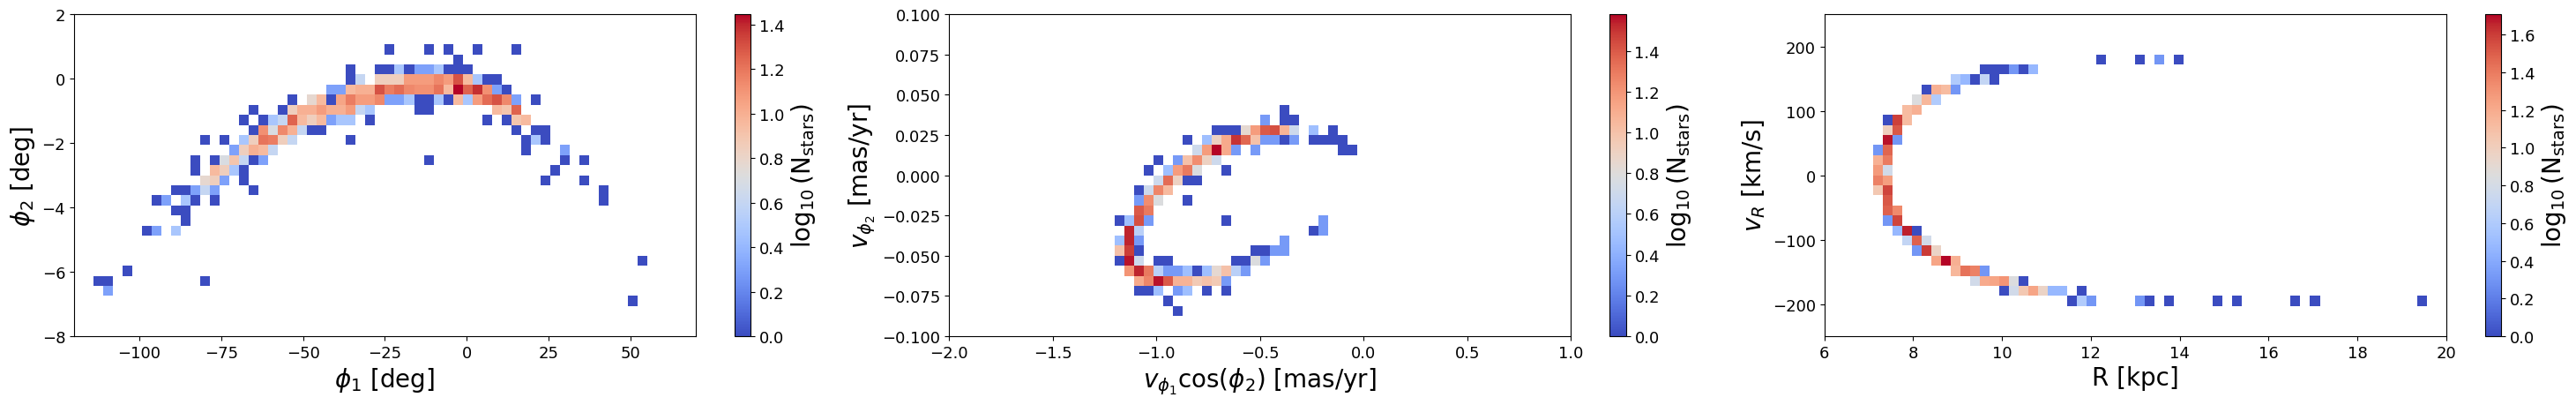

In [11]:
import matplotlib.colors as colors

fig = plt.figure(figsize=(30, 5), tight_layout=True)

# Define bin edges and create meshgrids
phi1_bins = jnp.linspace(-120, 70, 65)    # 64 bins
phi2_bins = jnp.linspace(-8, 2, 33)       # 32 bins
v1_bins = jnp.linspace(-2., 1.0, 65)      # 64 bins  
v2_bins = jnp.linspace(-0.10, 0.10, 33)   # 32 bins
R_bins = jnp.linspace(6, 20, 65)          # 64 bins
vR_bins = jnp.linspace(-250, 250, 33)     # 32 bins

# Create meshgrids for bin edges (not centers)
PHI1, PHI2 = jnp.meshgrid(phi1_bins, phi2_bins, indexing='ij')
V1, V2 = jnp.meshgrid(v1_bins, v2_bins, indexing='ij')
R_GRID, VR_GRID = jnp.meshgrid(R_bins, vR_bins, indexing='ij')

# Create 2D histograms
ax = fig.add_subplot(131)
counts1 = jnp.histogram2d(phi1, phi2, bins=[phi1_bins, phi2_bins])[0]
im1 = ax.pcolormesh(PHI1, PHI2, np.log10(counts1), cmap='coolwarm')
ax.set_xlabel("$\phi_1$ [deg]")
ax.set_ylabel("$\phi_2$ [deg]")
ax.set_xlim(-120, 70)
ax.set_ylim(-8, 2)
# Define a normalization that centers white at 0
plt.colorbar(im1, ax=ax, label=r'$\log_{10}(\text{N}_{\text{stars}})$',  )

ax = fig.add_subplot(132)
counts2 = jnp.histogram2d(v1_cosphi2, v2, bins=[v1_bins, v2_bins])[0]
im2 = ax.pcolormesh(V1, V2, np.log10(counts2), cmap='coolwarm')
ax.set_xlabel("$v_{\phi_1}\cos(\phi_2)$ [mas/yr]")
ax.set_ylabel("$v_{\phi_2}$ [mas/yr]")
ax.set_xlim(-2., 1.0)
ax.set_ylim(-0.10, 0.10)
plt.colorbar(im2, ax=ax, label=r'$\log_{10}(\text{N}_{\text{stars}})$')

ax = fig.add_subplot(133)
counts3 = jnp.histogram2d(R, vR, bins=[R_bins, vR_bins])[0]
im3 = ax.pcolormesh(R_GRID, VR_GRID, np.log10(counts3), cmap='coolwarm')
ax.set_xlabel("R [kpc]")
ax.set_ylabel("$v_R$ [km/s]")
ax.set_xlim(6, 20)
ax.set_ylim(-250, 250)
plt.colorbar(im3, ax=ax, label=r'$\log_{10}(\text{N}_{\text{stars}})$')

(-8.0, 2.0)

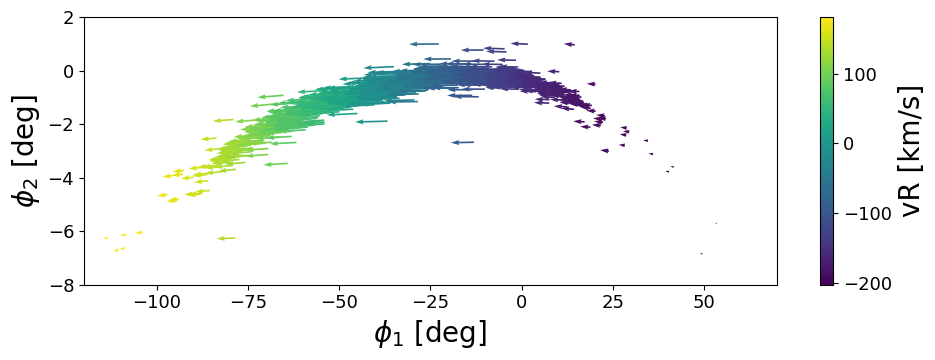

In [12]:
# Plotting the vector field of velocities
fig  = plt.figure(figsize=(10, 4), tight_layout=True)
ax = fig.add_subplot(111)
vectorf_field = ax.quiver(phi1, 
                            phi2,
                            v1_cosphi2/jnp.cos(jnp.deg2rad(phi2)),
                            v2,
                            vR,
                            scale=25,)
plt.colorbar(vectorf_field, ax=ax, label='vR [km/s]')
ax.set_xlabel("$\phi_1$ [deg]")
ax.set_ylabel("$\phi_2$ [deg]")
ax.set_xlim(-120, 70)
ax.set_ylim(-8, 2)

In [13]:
target_stream = projection_on_GD1(snapshots.states[-1, :], code_units=code_units ) # Reshape to (N_particles, 6)
target_stream.shape

(1000, 6)

# 1D case

## t_end

## Brute force searching 

Gradient of the total mass of the t_end:
 -2.4080286
Loss:
 -0.024494058


Text(0, 0.5, 'Loss')

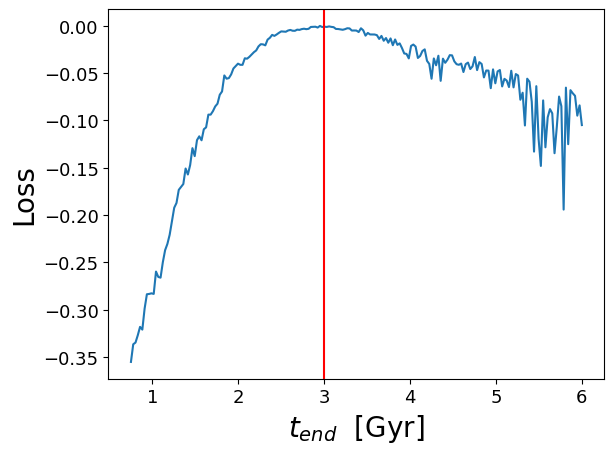

In [ ]:
# Gradient on t_end 
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)
stream_target = s

def normalize_data(X):
    """Z-score normalization"""
    mean = jnp.mean(X, axis=0)
    std = jnp.std(X, axis=0)
    return (X - mean) / std, mean, std

# Your stream data: [R, phi1, phi2, vR, v1_cosphi2, v2]
def normalize_stream_data(stream):
    """Normalize stellar stream data for RBF"""
    
    # Remove NaN values first
    mask = ~jnp.isnan(stream).any(axis=1)
    stream_clean = stream[mask]
    
    # Normalize each dimension
    stream_norm, mean, std = normalize_data(stream_clean)
    
    return stream_norm, mean, std

# target_norm, mean, std = normalize_stream_data(stream_target)
target_norm = stream_target

@jit
def rbf_kernel(x, y, sigma):
    """RBF kernel optimized for 6D astronomical data"""
    return jnp.exp(-jnp.sum((x - y)**2) / (2 * sigma**2))

@jit 
def compute_mmd(sim_norm, target_norm, sigmas):
    xx = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda xj: rbf_kernel(xi, xj, sigmas))(sim_norm))(sim_norm))
    yy = jnp.mean(jax.vmap(lambda yi: jax.vmap(lambda yj: rbf_kernel(yi, yj, sigmas))(target_norm))(target_norm))
    xy = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda yj: rbf_kernel(xi, yj, sigmas))(target_norm))(sim_norm))
    return xx + yy - 2 * xy

@jit
def adatptive_bandwidth_mmd(sim_norm, target_norm):
    """Adaptive bandwidth MMD for 6D data"""
    n_sim, n_target = len(sim_norm), len(target_norm)
    # Rule of thumb for adaptive bandwidth
    sigma = 2 * jnp.power(n_sim + n_target, -1/(6+4))  # Adjusted for 6D data
    return compute_mmd(sim_norm, target_norm, sigma)

@jit 
def percintile_based_mmd(sim_norm, target_norm, scale_weights = jnp.array([0.1, 0.1, 0.3, 0.25, 0.25])):
    """MMD using percentiles as natural scales"""
    distances = jax.vmap(lambda x: jax.vmap(lambda y: jnp.linalg.norm(x - y))(target_norm))(sim_norm)
    distance_flat = distances.flatten()

    # Use percentiles as natural scales
    sigmas = jnp.array([
        jnp.percentile(distance_flat, 10),   # Fine scale
        jnp.percentile(distance_flat, 25),   # Small scale  
        jnp.percentile(distance_flat, 50),   # Medium scale (median)
        jnp.percentile(distance_flat, 75),   # Large scale
        jnp.percentile(distance_flat, 90),   # Very large scale
    ])

    
    mmd = jnp.sum(scale_weights * jax.vmap(lambda sigma: compute_mmd(sim_norm, target_norm, sigma))(sigmas))/len(sigmas)
    return mmd 


@jit 
def percintile_based_mmd_with_noise(sim_norm, target_norm, 
                                   scale_weights=jnp.array([0.1, 0.1, 0.3, 0.25, 0.25]),
                                   poisson_weight=1e-3, 
                                   gaussian_weight=0.5,
                                   noise_std=jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0])):
    """MMD using percentiles as natural scales with Poisson and Gaussian noise regularization"""
    
    # Original MMD computation
    distances = jax.vmap(lambda x: jax.vmap(lambda y: jnp.linalg.norm(x - y))(target_norm))(sim_norm)
    distance_flat = distances.flatten()

    # Use percentiles as natural scales
    sigmas = jnp.array([
        jnp.percentile(distance_flat, 10),   # Fine scale
        jnp.percentile(distance_flat, 25),   # Small scale  
        jnp.percentile(distance_flat, 50),   # Medium scale (median)
        jnp.percentile(distance_flat, 75),   # Large scale
        jnp.percentile(distance_flat, 90),   # Very large scale
    ])
    
    # Base MMD computation
    base_mmd = jnp.sum(scale_weights * jax.vmap(lambda sigma: compute_mmd(sim_norm, target_norm, sigma))(sigmas))
    
    # === Poisson Noise Component ===
    # Account for shot noise in sparse regions
    n_sim, n_target = len(sim_norm), len(target_norm)
    
    # Estimate effective sample sizes (accounting for clustering)
    effective_n_sim = jnp.sqrt(n_sim)  # Conservative estimate for clustered data
    effective_n_target = jnp.sqrt(n_target)
    
    # Poisson noise penalty (higher penalty for fewer samples)
    poisson_penalty = poisson_weight * (1.0 / effective_n_sim + 1.0 / effective_n_target)
    
    # === Gaussian Error Component ===
    # Account for measurement uncertainties in each dimension
    
    # Dimension-wise error propagation
    def gaussian_error_kernel(x, y, sigma, noise_std):
        """Modified RBF kernel accounting for Gaussian measurement errors"""
        # Add measurement noise to the kernel width
        effective_sigma_sq = sigma**2 + jnp.sum(noise_std**2)
        return jnp.exp(-jnp.sum((x - y)**2) / (2 * effective_sigma_sq))
    
    # Compute error-aware MMD for the median scale (most representative)
    median_sigma = sigmas[2]  # 50th percentile
    
    # Error-corrected kernel matrices
    xx_err = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda xj: 
        gaussian_error_kernel(xi, xj, median_sigma, noise_std))(sim_norm))(sim_norm))
    yy_err = jnp.mean(jax.vmap(lambda yi: jax.vmap(lambda yj: 
        gaussian_error_kernel(yi, yj, median_sigma, noise_std))(target_norm))(target_norm))
    xy_err = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda yj: 
        gaussian_error_kernel(xi, yj, median_sigma, noise_std))(target_norm))(sim_norm))
    
    error_corrected_mmd = xx_err + yy_err - 2 * xy_err
    
    # Gaussian error correction term
    gaussian_correction = gaussian_weight * jnp.abs(error_corrected_mmd - 
                                                   jax.vmap(lambda sigma: compute_mmd(sim_norm, target_norm, sigma))(sigmas)[2])
    
    return base_mmd + poisson_penalty + gaussian_correction

phi1_min = -100.
phi1_max = 0
@jit
def inomogeneus_poisson(sim_norm, target_norm, 
                        phi1_min=phi1_min, phi1_max=phi1_max, 
                        phi2_min=-8., phi2_max=3.,
                        bw=3, spur_ids=None):
    phi1_data, phi2_data = target_norm[:, 1], target_norm[:, 2]
    phi1_model, phi2_model = sim_norm[:, 1], sim_norm[:, 2]

    # phi1_data, phi2_data = sim_norm[:, 1], sim_norm[:, 2]
    # phi1_model, phi2_model = target_norm[:, 1], target_norm[:, 2]
    inp_data = jnp.vstack([phi1_data, phi2_data])
    inp_model = jnp.vstack([phi1_model, phi2_model])
    ## Weights for the kde: start with uniform
    weights = jnp.ones_like(phi1_model)
    ## Check where the model is outside of the domain (Omega)
    pred = (phi1_model < phi1_min) | (phi1_model > phi1_max) | (phi2_model < phi2_min) | (phi2_model > phi2_max)
    ## wherever the model is outsize of the domain, set the weights to zero.
    ## This way the model has no support outside of the domain
    weights = jnp.where( pred, 0.0, weights)
    ## N0 = N_model here
    N0 = jnp.sum(weights)
    weights = weights/weights.sum()
    ## Fit the kde
    kde = gaussian_kde(inp_model, bw_method=bw, weights=weights)
    ## N = N_data
    N = len(phi1_data)
    logpdf = kde.logpdf(inp_data)
    ## Next we define the w_i's, or the importance weights below
    ## Generate id list of importance weights
    # importance_weights_idx = jnp.arange(len(phi1_data))
    ## Check if importance weights are in spur_ids. If they are, assign a value of 1.5. Otherwise, 1.
    # importance_weights = jnp.where(jnp.isin(importance_weights_idx,spur_ids),1.5,1.) 

    importance_weights = jnp.ones_like(logpdf) 
    
    return  -N0 + N*jnp.log(N0) + jnp.sum(logpdf*importance_weights)

def inomogeneus_poisson_completeinformation(sim_norm, target_norm,):
    kde = gaussian_kde(target_norm.T, bw_method=3)
    weights = jnp.ones_like(target_norm[:, 0])
    N0 = len(target_norm)
    weights = weights / weights.sum()
    N = len(sim_norm)
    logpdf = kde.logpdf(sim_norm.T)
    importance_weights = jnp.ones_like(logpdf) 
    return -N0 + N * jnp.log(N0) + jnp.sum(logpdf * weights)


@jit
def time_integration_tend_grad(t_end, key):

    #Creation of the Plummer sphere requires a key 
    # key = random.PRNGKey(key)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(t_end = t_end,)
    new_params_com = params_com._replace(t_end = -t_end,)
    
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    N_background = int(1e6)
    #Generate the probability of selectin a background star
    background_selected = jnp.where(jax.random.uniform(key=key, shape=(N_background,)) < 1e-3, 1.0, 0.0)
    keys = random.split(key, N_background)
    # selected_background = jax.vmap(lambda key, background_star: jnp.where(background_star, background_assignement(key), jnp.nan))(keys, background_selected)

    # Combine the selected stream and background stars
    # stream = jnp.concatenate((selected_stream, selected_background), axis=0)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    #add gaussian noise to the stream
    noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0])
    stream = stream + jax.random.normal(key=jax.random.key(0), shape=stream.shape) * noise_std


     # Normalize to standard ranges for each dimension
    bounds = jnp.array([
        [6, 20],        # R [kpc]
        [-120, 70],     # phi1 [deg]  
        [-8, 2],        # phi2 [deg]
        [-250, 250],    # vR [km/s]
        [-2., 1.0],     # v1_cosphi2 [mas/yr]
        [-0.10, 0.10]   # v2 [mas/yr]
    ])
        
    # def normalize_stream(stream):
    #     # Normalize each dimension to [0,1]
    #     return (stream - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])
    
    
    # sim_norm = (stream - mean)/std
    sim_norm = stream

    ## adaptive bandwidth MMD calculation
    # return -0.1* adatptive_bandwidth_mmd(sim_norm, target_norm)

    ## percentile-based MMD calculation
    # return -0.1* percintile_based_mmd(sim_norm, target_norm, ) 

    ## percentile-based MMD with noise regularization
    # return percintile_based_mmd_with_noise(sim_norm, target_norm, )

    ## inhomogeneous Poisson process 
    # return inomogeneus_poisson(sim_norm, target_norm,)

    ## inomogeneous Poisson process with complete information
    # return inomogeneus_poisson_completeinformation(sim_norm, target_norm,)

    distances = jax.vmap(lambda x: jax.vmap(lambda y: jnp.linalg.norm(x - y))(target_norm))(sim_norm)
    distance_flat = distances.flatten()

    # Use percentiles as natural scales
    sigmas = jnp.array([
        jnp.percentile(distance_flat, 10),   # Fine scale
        jnp.percentile(distance_flat, 25),   # Small scale  
        jnp.percentile(distance_flat, 50),   # Medium scale (median)
        jnp.percentile(distance_flat, 75),   # Large scale
        jnp.percentile(distance_flat, 90),   # Very large scale
    ])

    # Adaptive weights based on scale separation
    scale_weights = jnp.array([0.1, 0.1, 0.3, 0.25, 0.25])
    scale_weights = jnp.ones_like(sigmas)  # Equal weights for simplicity

    # Compute MMD with multiple kernels
    mmd_total = jnp.sum(scale_weights * jax.vmap(lambda sigma: compute_mmd(sim_norm, target_norm, sigma))(sigmas))
    
    return -1 * mmd_total / len(sigmas)

# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
t_end = params.t_end*(3/4) 
key = random.PRNGKey(0)
loss, grad = jax.value_and_grad(time_integration_tend_grad, )(t_end, key)
print("Gradient of the total mass of the t_end:\n", grad)
print("Loss:\n", loss)  
n_sim = 199
keys = random.split(random.PRNGKey(0), n_sim)
t_end = np.linspace(params.t_end*(1/4), params.t_end*(8/4), n_sim) 
# Correct way to append - assign the result back to Mvir
# t_end = np.concatenate([t_end, np.array([params.t_end])]) # Append the true Mvir value
t_end = jnp.array(np.sort(t_end))

# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)

mesh = Mesh(np.array(jax.devices()), ("i",))
t_end_sharded = jax.device_put(jnp.log10(t_end), NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))

@jit
def time_integration_NFW_tend_map(t_end_and_key):
    t_end, key = t_end_and_key
    t_end = 10**t_end
    return jax.value_and_grad(time_integration_tend_grad)(t_end, key)

loss, grad = jax.lax.map(
    time_integration_NFW_tend_map, 
    (t_end_sharded, keys_sharded), 
    batch_size=5,
)

plt.figure()
plt.plot(t_end*(code_units.code_time).to(u.Gyr), loss)
plt.axvline(params.t_end*(code_units.code_time).to(u.Gyr), color='r', label='True $t_{end}$')
plt.xlabel("$t_{end}$  [Gyr]")
plt.ylabel('Loss')
# plt.savefig('./loss_landscape/loss_landscape_t_end.pdf')


In [15]:
# hessian = jax.hessian(time_integration_tend_grad, )(jnp.array(params.t_end), random.PRNGKey(0))
# print("Hessian:\n", hessian)

In [19]:
print(t_end[jnp.argmax(loss)] * code_units.code_time.to(u.Gyr), "Gyr")

2.9507575 Gyr


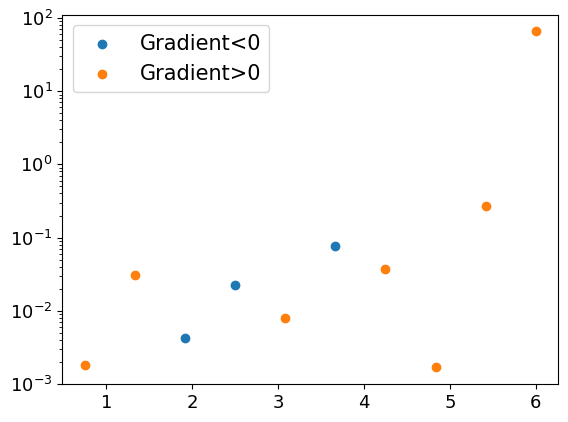

In [61]:
plt.scatter(t_end[grad<0]*(code_units.code_time).to(u.Gyr) , abs(grad[grad<0]), label='Gradient<0')
plt.scatter(t_end[grad>0]*(code_units.code_time).to(u.Gyr), abs(grad[grad>0]), label='Gradient>0')
plt.plot()
plt.yscale('log')
plt.legend()

## Gradient descent around the minimum

In [ ]:
from jaxopt import ScipyMinimize, LBFGS
import optax
import optimistix as optx
from tqdm import tqdm

# We pick gradient descent for pedagogical and visualization reasons.
# In practice one would use e.g. Levenberg-Marquardt from the
# optimistix package.

# from functools import partial
# @partial(jit, static_argnames=('func','learning_rate', 'tol', 'max_iter'))
# def gradient_descent_optimization(func, x_init, key, learning_rate=20, tol=0.5, max_iter=2000):
#     # xlist = jnp.zeros((max_iter + 1, x_init.shape[0]))
#     xlist = []
#     x = x_init
#     loss_list = []
#     # loss_list = jnp.zeros(max_iter + 1)

#     xlist.append(x)
#     # xlist = xlist.at[0].set(x)  # Initialize the first element with x_init

#     # ADAM optimizer
#     optimizer = optax.adam(learning_rate=learning_rate)
#     optimizer_state = optimizer.init(x)

#     #SCHEDULE FREE ADAM
#     # learning_rate_fn = optax.warmup_constant_schedule(peak_value=learning_rate, warmup_steps=10, init_value=0.0)
#     # optimizer = optax.adam(learning_rate_fn, b1=0.)
#     # optimizer = optax.contrib.schedule_free(optimizer, learning_rate_fn, b1=0.9)
#     # optimizer_state = optimizer.init(x)

#     #SCHEDULE FREE ADAMW
#     # optimizer = optax.contrib.schedule_free_adamw(learning_rate)
#     # optimizer_state = optimizer.init(x)


#     for _ in tqdm(range(max_iter)):
#         # Compute the function value and its gradient
#         loss, f_grad = jax.value_and_grad(func)(x, key)
#         loss_list.append(loss)
#         # loss_list = loss_list.at[_].set(loss)
        
#         # Update the parameter
#         updates, optimizer_state = optimizer.update(-f_grad, optimizer_state, x)
#         x = optax.apply_updates(x, updates)
#         key = random.split(key, 1)[0]  # Update the key for the next iteration
#         xlist.append(x)
#         # xlist = xlist.at[_ + 1].set(x)
        
#         # Check convergence
#         if jnp.linalg.norm(updates) < tol:
#             break
    
#     return x, xlist, loss_list




In [63]:
@jit
def time_integration_t_endlog(t_end, key):
    """Wrapper function to compute the loss for a given t_end."""
    t_end = 10**t_end  # Convert log scale back to original scale
    return time_integration_tend_grad(t_end, key)

In [135]:
@jit 
def time_integration_t_endlog_gradascend(params, key):
    t_end = 10**params['t_end']
    return time_integration_tend_grad(t_end, key)

### Gradient of ln-likelihood is simple as
grad_func = jax.grad(time_integration_t_endlog_gradascend)

def gradient_ascent(params, learning_rates, num_iterations):
    trajectory = []
    loglike = []
    keys = []
    key = random.PRNGKey(1)  # Initialize a random key for reproducibility
    for i in range(num_iterations):
        grads = grad_func(params, key)
        params = {k: v + learning_rates[k] * grads[k] for k, v in params.items()}
        ll = time_integration_t_endlog_gradascend(params, key)
        keys.append(key)
        key, _ = random.split(key)
        trajectory.append(params)
        loglike.append(ll)
        if i % 10 == 0:  # Print progress every 10 iterations
            arr = jnp.asarray(loglike)
            print(f"Iteration {i}, max lnlikelihood {str(arr.max())}")
    return params, trajectory, loglike, keys


lr = 1e-2
learning_rates = {
    't_end': lr,  # Learning rate for t_end
}

best_fit = {'t_end':jnp.log10(t_end[jnp.argmax(loss)]).item()}
nsteps = 10
params_final, traj, loglike_traj, keys = gradient_ascent(best_fit,learning_rates,nsteps) 

Iteration 0, max lnlikelihood -2.9628278e-05


In [136]:
loglike_traj = jnp.asarray(loglike_traj)
id_max = jnp.argmax(loglike_traj)
params_MLE = traj[id_max]

print(10**params_MLE['t_end']*code_units.code_time.to(u.Gyr), "Gyr")

hessian = jax.hessian(time_integration_t_endlog_gradascend)(params_MLE, keys[id_max])
print("Hessian at MLE:\n", hessian)

3.091515 Gyr
Hessian at MLE:
 {'t_end': {'t_end': Array(426.0944, dtype=float32, weak_type=True)}}


In [137]:
fisher_information = jnp.sqrt(-hessian['t_end']['t_end']**-1)


physical_t_end = 10**params_MLE['t_end'] 
print("Fisher information for t_end:", physical_t_end * code_units.code_time.to('Gyr'), "Gyr")
print("Fisher information for t_end:", physical_t_end*jnp.log(10)*fisher_information * code_units.code_time.to('Gyr'), "Gyr")



Fisher information for t_end: 3.091515 Gyr
Fisher information for t_end: nan Gyr


In [ ]:
x1, xlist, loss_list = gradient_descent_optimization(
    time_integration_t_endlog, 
    np.log10(t_end[jnp.argmin(loss)]),  
    random.PRNGKey(32), 
    learning_rate=0.01,
    tol=1e-6, 
    max_iter=200)

100%|██████████| 200/200 [03:25<00:00,  1.03s/it]


In [57]:
x1 = 10**x1  # Convert back to original scale
xlist= 10**jnp.array(xlist)  # Convert back to original scale

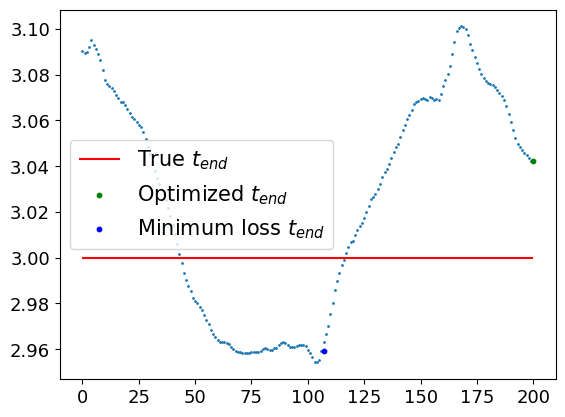

In [58]:
plt.scatter(jnp.arange(len(xlist[1:])), 
            jnp.array([xlist[1:]])*code_units.code_time.to(u.Gyr),
            s=1  )
plt.hlines(y=params.t_end*code_units.code_time.to(u.Gyr), xmin=0, xmax=len(xlist[1:]) , label='True $t_{end}$', color='r')
plt.scatter(len(xlist[1:]), 
            x1*code_units.code_time.to(u.Gyr), s=10, label='Optimized $t_{end}$', color='g')
plt.scatter(np.argmin(loss_list[1:]),
            xlist[np.argmin(loss_list[1:])]*code_units.code_time.to(u.Gyr),
            s=10, label='Minimum loss $t_{end}$', color='b')
plt.legend()

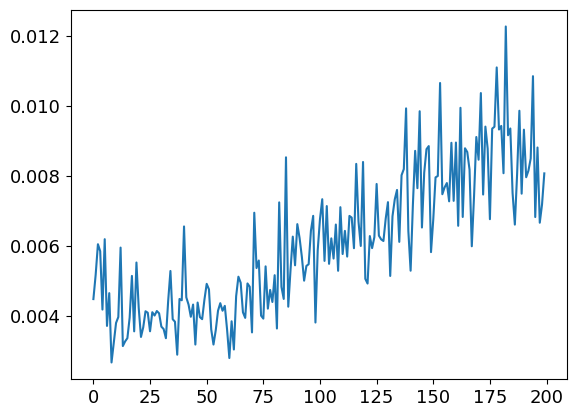

In [53]:
plt.plot(loss_list)

In [32]:
@jit 
def time_integration_for_langevin(params, key):
    t_end = 10**params['t_end']
    return time_integration_tend_grad(t_end, key)


## Lagevin sampling

In [33]:
from tqdm import tqdm 

def langevin_sampler(initial_params, num_samples, step_size, rng_key):
    samples = []
    params = initial_params
    for i in tqdm(range(num_samples)):
        grads = jax.jacfwd(time_integration_for_langevin)(params, rng_key)
        noise = jax.random.normal(rng_key, shape=jnp.array(list(params.values())).shape)
        params = {k: v + 0.5 * step_size * grads[k] + jnp.sqrt(step_size) * noise[idx] for idx, (k, v) in enumerate(params.items())}
        samples.append(params)
        rng_key, _ = jax.random.split(rng_key)
    return samples

In [34]:
lr = 1e-10 
learning_rates = {'t_end': lr}

In [41]:
params_MLE = {'t_end': jnp.log10(xlist[np.argmin(loss_list[1:])])}
rng_key = random.PRNGKey(42)
out_samps = langevin_sampler(params_MLE,5000,1e-5,rng_key)

100%|██████████| 5000/5000 [27:33<00:00,  3.02it/s]


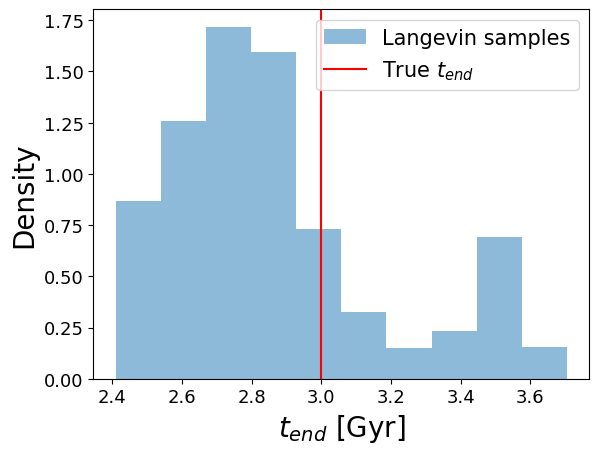

In [42]:
plt.hist([10**samp['t_end']*code_units.code_time.to(u.Gyr) for samp in out_samps], density=True, alpha=0.5, label='Langevin samples')
plt.axvline(params.t_end*code_units.code_time.to(u.Gyr), color='r', label='True $t_{end}$')
plt.xlabel("$t_{end}$ [Gyr]")
plt.ylabel("Density")
plt.legend()

Parameter t_end in chain Langevin samples is not constrained


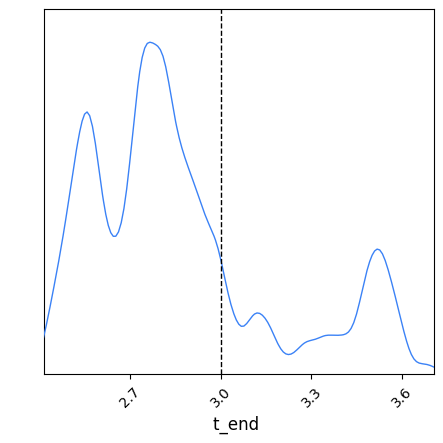

In [48]:
from chainconsumer import Chain, ChainConsumer, Truth
import pandas as pd

df = pd.DataFrame(out_samps, columns=['t_end'])
df['t_end'] = 10**df['t_end'] * code_units.code_time.to(u.Gyr)
df['t_end'] = df['t_end'].astype(float) 
df.dropna(inplace=True)
c = ChainConsumer()
c.add_chain(Chain(samples=df, name='Langevin samples'))
c.add_truth(Truth(location={'t_end': params.t_end* code_units.code_time.to(u.Gyr)}), )
fig = c.plotter.plot()

## M_NFW

## Brute force searching 

Gradient of the total mass of the t_end:
 1.6608803
Loss:
 0.021259183


Text(0, 0.5, 'Loss')

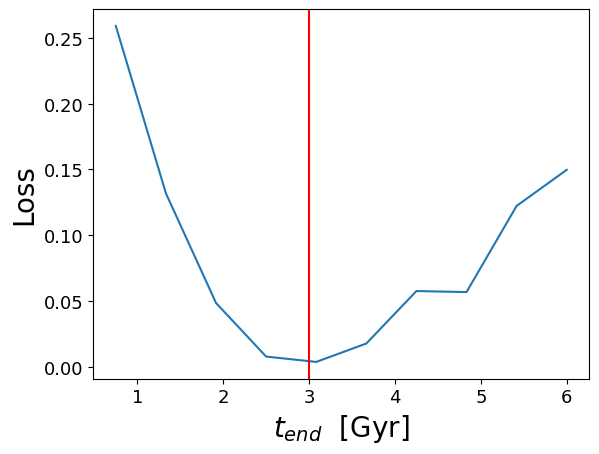

In [ ]:
# Gradient on t_end 
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)
stream_target = s

def normalize_data(X):
    """Z-score normalization"""
    mean = jnp.mean(X, axis=0)
    std = jnp.std(X, axis=0)
    return (X - mean) / std, mean, std

# Your stream data: [R, phi1, phi2, vR, v1_cosphi2, v2]
def normalize_stream_data(stream):
    """Normalize stellar stream data for RBF"""
    
    # Remove NaN values first
    mask = ~jnp.isnan(stream).any(axis=1)
    stream_clean = stream[mask]
    
    # Normalize each dimension
    stream_norm, mean, std = normalize_data(stream_clean)
    
    return stream_norm, mean, std

target_norm, mean, std = normalize_stream_data(stream_target)
# target_norm = stream_target

@jit
def rbf_kernel(x, y, sigma):
    """RBF kernel optimized for 6D astronomical data"""
    return jnp.exp(-jnp.sum((x - y)**2) / (2 * sigma**2))

@jit 
def compute_mmd(sim_norm, target_norm, sigmas):
    xx = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda xj: rbf_kernel(xi, xj, sigmas))(sim_norm))(sim_norm))
    yy = jnp.mean(jax.vmap(lambda yi: jax.vmap(lambda yj: rbf_kernel(yi, yj, sigmas))(target_norm))(target_norm))
    xy = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda yj: rbf_kernel(xi, yj, sigmas))(target_norm))(sim_norm))
    return xx + yy - 2 * xy

@jit
def adatptive_bandwidth_mmd(sim_norm, target_norm):
    """Adaptive bandwidth MMD for 6D data"""
    n_sim, n_target = len(sim_norm), len(target_norm)
    # Rule of thumb for adaptive bandwidth
    sigma = 2 * jnp.power(n_sim + n_target, -1/(6+4))  # Adjusted for 6D data
    return compute_mmd(sim_norm, target_norm, sigma)

@jit 
def percintile_based_mmd(sim_norm, target_norm, scale_weights = jnp.array([0.1, 0.1, 0.3, 0.25, 0.25])):
    """MMD using percentiles as natural scales"""
    distances = jax.vmap(lambda x: jax.vmap(lambda y: jnp.linalg.norm(x - y))(target_norm))(sim_norm)
    distance_flat = distances.flatten()

    # Use percentiles as natural scales
    sigmas = jnp.array([
        jnp.percentile(distance_flat, 10),   # Fine scale
        jnp.percentile(distance_flat, 25),   # Small scale  
        jnp.percentile(distance_flat, 50),   # Medium scale (median)
        jnp.percentile(distance_flat, 75),   # Large scale
        jnp.percentile(distance_flat, 90),   # Very large scale
    ])

    
    return jnp.sum(scale_weights * jax.vmap(lambda sigma: compute_mmd(sim_norm, target_norm, sigma))(sigmas))/len(sigmas)


@jit 
def percintile_based_mmd_with_noise(sim_norm, target_norm, 
                                   scale_weights=jnp.array([0.1, 0.1, 0.3, 0.25, 0.25]),
                                   poisson_weight=1e-3, 
                                   gaussian_weight=0.5,
                                   noise_std=jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0])):
    """MMD using percentiles as natural scales with Poisson and Gaussian noise regularization"""
    
    # Original MMD computation
    distances = jax.vmap(lambda x: jax.vmap(lambda y: jnp.linalg.norm(x - y))(target_norm))(sim_norm)
    distance_flat = distances.flatten()

    # Use percentiles as natural scales
    sigmas = jnp.array([
        jnp.percentile(distance_flat, 10),   # Fine scale
        jnp.percentile(distance_flat, 25),   # Small scale  
        jnp.percentile(distance_flat, 50),   # Medium scale (median)
        jnp.percentile(distance_flat, 75),   # Large scale
        jnp.percentile(distance_flat, 90),   # Very large scale
    ])
    
    # Base MMD computation
    base_mmd = jnp.sum(scale_weights * jax.vmap(lambda sigma: compute_mmd(sim_norm, target_norm, sigma))(sigmas))
    
    # === Poisson Noise Component ===
    # Account for shot noise in sparse regions
    n_sim, n_target = len(sim_norm), len(target_norm)
    
    # Estimate effective sample sizes (accounting for clustering)
    effective_n_sim = jnp.sqrt(n_sim)  # Conservative estimate for clustered data
    effective_n_target = jnp.sqrt(n_target)
    
    # Poisson noise penalty (higher penalty for fewer samples)
    poisson_penalty = poisson_weight * (1.0 / effective_n_sim + 1.0 / effective_n_target)
    
    # === Gaussian Error Component ===
    # Account for measurement uncertainties in each dimension
    
    # Dimension-wise error propagation
    def gaussian_error_kernel(x, y, sigma, noise_std):
        """Modified RBF kernel accounting for Gaussian measurement errors"""
        # Add measurement noise to the kernel width
        effective_sigma_sq = sigma**2 + jnp.sum(noise_std**2)
        return jnp.exp(-jnp.sum((x - y)**2) / (2 * effective_sigma_sq))
    
    # Compute error-aware MMD for the median scale (most representative)
    median_sigma = sigmas[2]  # 50th percentile
    
    # Error-corrected kernel matrices
    xx_err = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda xj: 
        gaussian_error_kernel(xi, xj, median_sigma, noise_std))(sim_norm))(sim_norm))
    yy_err = jnp.mean(jax.vmap(lambda yi: jax.vmap(lambda yj: 
        gaussian_error_kernel(yi, yj, median_sigma, noise_std))(target_norm))(target_norm))
    xy_err = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda yj: 
        gaussian_error_kernel(xi, yj, median_sigma, noise_std))(target_norm))(sim_norm))
    
    error_corrected_mmd = xx_err + yy_err - 2 * xy_err
    
    # Gaussian error correction term
    gaussian_correction = gaussian_weight * jnp.abs(error_corrected_mmd - 
                                                   jax.vmap(lambda sigma: compute_mmd(sim_norm, target_norm, sigma))(sigmas)[2])
    
    return base_mmd + poisson_penalty + gaussian_correction

phi1_min = -100.
phi1_max = -50.
@jit
def inomogeneus_poisson(sim_norm, target_norm, 
                        phi1_min=phi1_min, phi1_max=phi1_max, 
                        phi2_min=-8., phi2_max=3.,
                        bw=3, spur_ids=None):
    phi1_data, phi2_data = target_norm[:, 1], target_norm[:, 2]
    phi1_model, phi2_model = sim_norm[:, 1], sim_norm[:, 2]

    # phi1_data, phi2_data = sim_norm[:, 1], sim_norm[:, 2]
    # phi1_model, phi2_model = target_norm[:, 1], target_norm[:, 2]
    inp_data = jnp.vstack([phi1_data, phi2_data])
    inp_model = jnp.vstack([phi1_model, phi2_model])
    ## Weights for the kde: start with uniform
    weights = jnp.ones_like(phi1_model)
    ## Check where the model is outside of the domain (Omega)
    pred = (phi1_model < phi1_min) | (phi1_model > phi1_max) | (phi2_model < phi2_min) | (phi2_model > phi2_max)
    ## wherever the model is outsize of the domain, set the weights to zero.
    ## This way the model has no support outside of the domain
    weights = jnp.where( pred, 0.0, weights)
    ## N0 = N_model here
    N0 = jnp.sum(weights)
    weights = weights/weights.sum()
    ## Fit the kde
    kde = gaussian_kde(inp_model, bw_method='silverman', weights=weights)
    ## N = N_data
    N = len(phi1_data)
    logpdf = kde.logpdf(inp_data)
    ## Next we define the w_i's, or the importance weights below
    ## Generate id list of importance weights
    # importance_weights_idx = jnp.arange(len(phi1_data))
    ## Check if importance weights are in spur_ids. If they are, assign a value of 1.5. Otherwise, 1.
    # importance_weights = jnp.where(jnp.isin(importance_weights_idx,spur_ids),1.5,1.) 

    importance_weights = jnp.ones_like(logpdf) 
    
    return  -N0 + N*jnp.log(N0) + jnp.sum(logpdf*importance_weights)




@jit
def time_integration_M_NFW_grad(M_NFW, key):

    #Creation of the Plummer sphere requires a key 
    # key = random.PRNGKey(key)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = new_params._replace(NFW_params = params.NFW_params._replace(Mvir = M_NFW, ))
    new_params_com = new_params_com._replace(NFW_params = params_com.NFW_params._replace(Mvir = M_NFW, ))

    
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    N_background = int(1e6)
    #Generate the probability of selectin a background star
    background_selected = jnp.where(jax.random.uniform(key=key, shape=(N_background,)) < 1e-3, 1.0, 0.0)
    keys = random.split(key, N_background)
    # selected_background = jax.vmap(lambda key, background_star: jnp.where(background_star, background_assignement(key), jnp.nan))(keys, background_selected)

    # Combine the selected stream and background stars
    # stream = jnp.concatenate((selected_stream, selected_background), axis=0)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    #add gaussian noise to the stream
    noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0])
    stream = stream + jax.random.normal(key=jax.random.key(0), shape=stream.shape) * noise_std


     # Normalize to standard ranges for each dimension
    bounds = jnp.array([
        [6, 20],        # R [kpc]
        [-120, 70],     # phi1 [deg]  
        [-8, 2],        # phi2 [deg]
        [-250, 250],    # vR [km/s]
        [-2., 1.0],     # v1_cosphi2 [mas/yr]
        [-0.10, 0.10]   # v2 [mas/yr]
    ])
        
    # def normalize_stream(stream):
    #     # Normalize each dimension to [0,1]
    #     return (stream - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])
    
    
    sim_norm = (stream - mean)/std
    # sim_norm = stream

    ## adaptive bandwidth MMD calculation
    # return adatptive_bandwidth_mmd(sim_norm, target_norm)

    ## percentile-based MMD calculation
    # return percintile_based_mmd(sim_norm, target_norm, ) 

    ## percentile-based MMD with noise regularization
    # return percintile_based_mmd_with_noise(sim_norm, target_norm, )

    ## inhomogeneous Poisson process 
    # return inomogeneus_poisson(sim_norm, target_norm,)


    distances = jax.vmap(lambda x: jax.vmap(lambda y: jnp.linalg.norm(x - y))(target_norm))(sim_norm)
    distance_flat = distances.flatten()

    # Use percentiles as natural scales
    sigmas = jnp.array([
        jnp.percentile(distance_flat, 10),   # Fine scale
        jnp.percentile(distance_flat, 25),   # Small scale  
        jnp.percentile(distance_flat, 50),   # Medium scale (median)
        jnp.percentile(distance_flat, 75),   # Large scale
        jnp.percentile(distance_flat, 90),   # Very large scale
    ])

    # Adaptive weights based on scale separation
    scale_weights = jnp.array([0.1, 0.1, 0.3, 0.25, 0.25])
    scale_weights = jnp.ones_like(sigmas)  # Equal weights for simplicity

    # Compute MMD with multiple kernels
    mmd_total = jnp.sum(scale_weights * jax.vmap(lambda sigma: compute_mmd(sim_norm, target_norm, sigma))(sigmas))
    
    return mmd_total / len(sigmas)

# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
M_NFW = params.NFW_params.Mvir*(3/4) 
key = random.PRNGKey(0)
loss, grad = jax.value_and_grad(time_integration_M_NFW_grad, )(t_end, key)
print("Gradient of the total mass of the t_end:\n", grad)
print("Loss:\n", loss)  

n_sim = 10
keys = random.split(random.PRNGKey(0), n_sim)
M_NFW = np.linspace(params.NFW_params.Mvir*(1/4), params.NFW_params.Mvir*(8/4), n_sim)
# Correct way to append - assign the result back to Mvir
# t_end = np.concatenate([t_end, np.array([params.t_end])]) # Append the true Mvir value
M_NFW = jnp.array(np.sort(M_NFW))

# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)

mesh = Mesh(np.array(jax.devices()), ("i",))
M_NFW_sharded = jax.device_put(jnp.log10(M_NFW), NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))

@jit
def time_integration_NFW_tend_map(M_NFW_and_key):
    M_NFW, key = M_NFW_and_key
    M_NFW = 10**t_end
    return jax.value_and_grad(time_integration_tend_grad)(M_NFW, key)

loss, grad = jax.lax.map(
    time_integration_NFW_tend_map, 
    (M_NFW_sharded, keys_sharded), 
    batch_size=1,
)

plt.figure()
plt.plot(M_NFW*(code_units.code_mass).to(u.Msun), loss)
plt.axvline(params.NFW_params.Mvir*(code_units.code_mass).to(u.Msun), color='r', label='True $t_{end}$')
plt.xlabel("$M_{NFW}$  [$M_{\odot}$]")
plt.ylabel('Loss')
# plt.savefig('./loss_landscape/loss_landscape_t_end.pdf')


In [ ]:
# hessian = jax.hessian(time_integration_tend_grad, )(jnp.array(params.t_end), random.PRNGKey(0))
# print("Hessian:\n", hessian)

In [ ]:
print(M_NFW[jnp.argmin(loss)] * code_units.code_mass.to(u.Msun), "Gyr")

3.0833335 Gyr


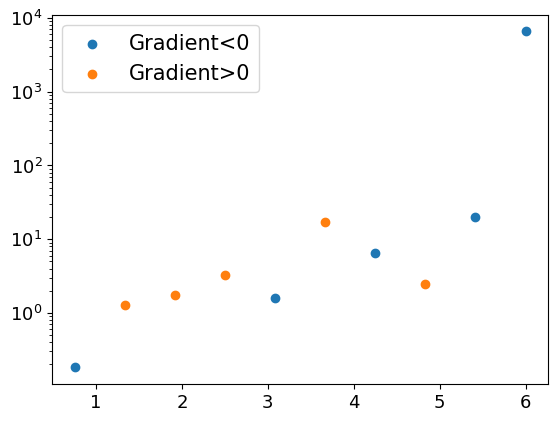

In [ ]:
plt.scatter(M_NFW[grad<0]*code_units.code_mass.to(u.Msun) , abs(grad[grad<0]), label='Gradient<0')
plt.scatter(M_NFW[grad>0]*code_units.code_mass.to(u.Msun), abs(grad[grad>0]), label='Gradient>0')
plt.plot()
plt.yscale('log')
plt.legend()

## Gradient descent around the minimum

In [ ]:
from jaxopt import ScipyMinimize, LBFGS
import optax
import optimistix as optx
from tqdm import tqdm

# We pick gradient descent for pedagogical and visualization reasons.
# In practice one would use e.g. Levenberg-Marquardt from the
# optimistix package.

# from functools import partial
# @partial(jit, static_argnames=('func','learning_rate', 'tol', 'max_iter'))
def gradient_descent_optimization(func, x_init, key, learning_rate=20, tol=0.5, max_iter=2000):
    # xlist = jnp.zeros((max_iter + 1, x_init.shape[0]))
    xlist = []
    x = x_init
    loss_list = []
    # loss_list = jnp.zeros(max_iter + 1)

    xlist.append(x)
    # xlist = xlist.at[0].set(x)  # Initialize the first element with x_init

    # ADAM optimizer
    # optimizer = optax.adam(learning_rate=learning_rate)
    # optimizer_state = optimizer.init(x)

    #SCHEDULE FREE ADAM
    # learning_rate_fn = optax.warmup_constant_schedule(peak_value=learning_rate, warmup_steps=10, init_value=0.0)
    # optimizer = optax.adam(learning_rate_fn, b1=0.)
    # optimizer = optax.contrib.schedule_free(optimizer, learning_rate_fn, b1=0.9)
    # optimizer_state = optimizer.init(x)

    #SCHEDULE FREE ADAMW
    optimizer = optax.contrib.schedule_free_adamw(learning_rate)
    optimizer_state = optimizer.init(x)


    for _ in tqdm(range(max_iter)):
        # Compute the function value and its gradient
        loss, f_grad = jax.value_and_grad(func)(x, key)
        loss_list.append(loss)
        # loss_list = loss_list.at[_].set(loss)
        
        # Update the parameter
        updates, optimizer_state = optimizer.update(-f_grad, optimizer_state, x)
        x = optax.apply_updates(x, updates)
        key = random.split(key, 1)[0]  # Update the key for the next iteration
        xlist.append(x)
        # xlist = xlist.at[_ + 1].set(x)
        
        # Check convergence
        if jnp.linalg.norm(updates) < tol:
            break
    
    return x, xlist, loss_list

In [ ]:
@jit
def time_integration_M_NFWlog(M_NFW, key):
    """Wrapper function to compute the loss for a given t_end."""
    M_NFW = 10**M_NFW  # Convert log scale back to original scale
    return time_integration_M_NFW_grad(M_NFW, key)

In [ ]:
x1, xlist, loss_list = gradient_descent_optimization(
    time_integration_M_NFWlog, 
    np.log10(M_NFW[jnp.argmin(loss)]),  
    random.PRNGKey(32), 
    learning_rate=0.01,
    tol=1e-6, 
    max_iter=200)

100%|██████████| 200/200 [03:28<00:00,  1.04s/it]


In [ ]:
x1 = 10**x1  # Convert back to original scale
xlist= 10**jnp.array(xlist)  # Convert back to original scale

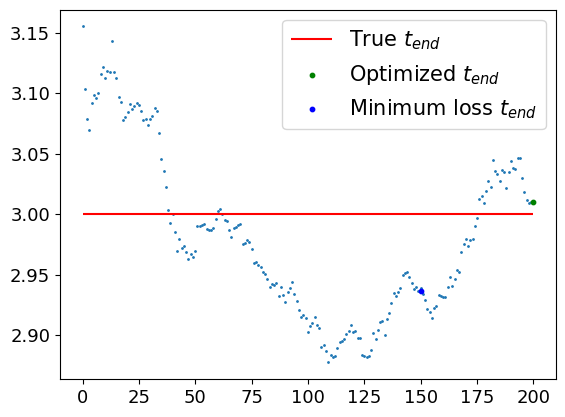

In [ ]:
plt.scatter(jnp.arange(len(xlist[1:])), 
            jnp.array([xlist[1:]])*code_units.code_time.to(u.Gyr),
            s=1  )
plt.hlines(y=params.t_end*code_units.code_time.to(u.Gyr), xmin=0, xmax=len(xlist[1:]) , label='True $t_{end}$', color='r')
plt.scatter(len(xlist[1:]), 
            x1*code_units.code_time.to(u.Gyr), s=10, label='Optimized $t_{end}$', color='g')
plt.scatter(np.argmin(loss_list[1:]),
            xlist[np.argmin(loss_list[1:])]*code_units.code_time.to(u.Gyr),
            s=10, label='Minimum loss $t_{end}$', color='b')
plt.legend()

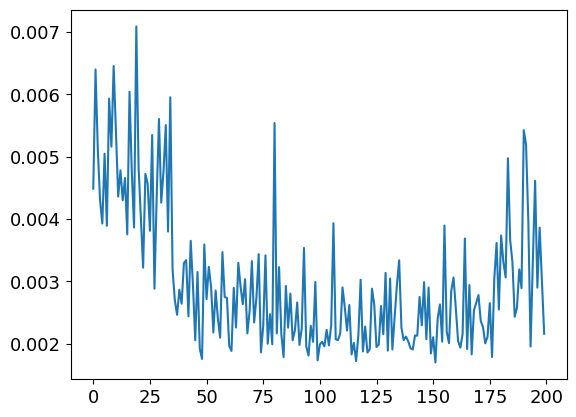

In [ ]:
plt.plot(loss_list)

In [ ]:
@jit 
def time_integration_for_langevin(params, key):
    M_NFW = 10**params['M_NFW']
    return time_integration_tend_grad(M_NFW, key)


## Lagevin sampling

In [ ]:
from tqdm import tqdm 

def langevin_sampler(initial_params, num_samples, step_size, rng_key):
    samples = []
    params = initial_params
    for i in tqdm(range(num_samples)):
        grads = jax.jacfwd(time_integration_for_langevin)(params, rng_key)
        noise = jax.random.normal(rng_key, shape=jnp.array(list(params.values())).shape)
        params = {k: v + 0.5 * step_size * grads[k] + jnp.sqrt(step_size) * noise[idx] for idx, (k, v) in enumerate(params.items())}
        samples.append(params)
        rng_key, _ = jax.random.split(rng_key)
    return samples

In [ ]:
lr = 1e-10 
learning_rates = {'t_end': lr}

In [ ]:
params_MLE = {'M_NFW': jnp.log10(xlist[np.argmin(loss_list[1:])])}
rng_key = random.PRNGKey(42)
out_samps = langevin_sampler(params_MLE,1000,1e-5,rng_key)

100%|██████████| 1000/1000 [06:57<00:00,  2.40it/s]


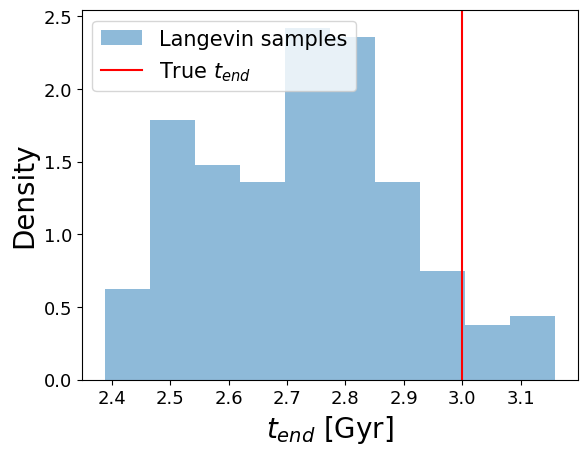

In [ ]:
plt.hist([10**samp['t_end']*code_units.code_mass.to(u.Msun) for samp in out_samps], density=True, alpha=0.5, label='Langevin samples')
plt.axvline(params.t_end*code_units.code_mass.to(u.Msun), color='r', label='True $t_{end}$')
plt.xlabel("$t_{end}$ [Gyr]")
plt.ylabel("Density")
plt.legend()

In [ ]:
from chainconsumer import Chain, ChainConsumer, Truth
import pandas as pd

df = pd.DataFrame(out_samps, columns=['$M_{NFW}$'])
df['$M_{NFW}$'] = 10**df['$M_{NFW}$'] * code_units.code_mass.to(u.Msun)
df['$M_{NFW}$'] = df['$M_{NFW}$'].astype(float) 
c = ChainConsumer()
c.add_chain(Chain(samples=df, name='Langevin samples'))
c.add_truth(Truth(location={'$M_{NFW}$': params.NFW_params.Mvir* code_units.code_mass.to(u.Msun)}), )
fig = c.plotter.plot()

# 2 PARAMETERTS


## Brute force 

In [14]:
# Gradient on t_end 
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)
stream_target = s

def normalize_data(X):
    """Z-score normalization"""
    mean = jnp.mean(X, axis=0)
    std = jnp.std(X, axis=0)
    return (X - mean) / std, mean, std

# Your stream data: [R, phi1, phi2, vR, v1_cosphi2, v2]
def normalize_stream_data(stream):
    """Normalize stellar stream data for RBF"""
    
    # Remove NaN values first
    mask = ~jnp.isnan(stream).any(axis=1)
    stream_clean = stream[mask]
    
    # Normalize each dimension
    stream_norm, mean, std = normalize_data(stream_clean)
    
    return stream_norm, mean, std

target_norm, mean, std = normalize_stream_data(stream_target)

@jit
def rbf_kernel(x, y, sigma):
    """RBF kernel optimized for 6D astronomical data"""
    return jnp.exp(-jnp.sum((x - y)**2) / (2 * sigma**2))

@jit 
def compute_mmd(sim_norm, target_norm, sigmas):
    xx = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda xj: rbf_kernel(xi, xj, sigmas))(sim_norm))(sim_norm))
    yy = jnp.mean(jax.vmap(lambda yi: jax.vmap(lambda yj: rbf_kernel(yi, yj, sigmas))(target_norm))(target_norm))
    xy = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda yj: rbf_kernel(xi, yj, sigmas))(target_norm))(sim_norm))
    return xx + yy - 2 * xy

@jit 
def percintile_based_mmd(sim_norm, target_norm, scale_weights = jnp.array([0.1, 0.1, 0.3, 0.25, 0.25])):
    """MMD using percentiles as natural scales"""
    distances = jax.vmap(lambda x: jax.vmap(lambda y: jnp.linalg.norm(x - y))(target_norm))(sim_norm)
    distance_flat = distances.flatten()

    # Use percentiles as natural scales
    sigmas = jnp.array([
        jnp.percentile(distance_flat, 10),   # Fine scale
        jnp.percentile(distance_flat, 25),   # Small scale  
        jnp.percentile(distance_flat, 50),   # Medium scale (median)
        jnp.percentile(distance_flat, 75),   # Large scale
        jnp.percentile(distance_flat, 90),   # Very large scale
    ])

    
    mmd = jnp.sum(scale_weights * jax.vmap(lambda sigma: compute_mmd(sim_norm, target_norm, sigma))(sigmas))/len(sigmas)
    return -mmd 

@jit
def time_integration_NFWM_tend_grad(M_NFW, t_end, key):



    key_Plummer, key_noise = jax.random.split(key, 2)
    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(t_end = t_end,)
    new_params = new_params._replace(NFW_params = params.NFW_params._replace(Mvir = M_NFW,))
    new_params_com = params_com._replace(t_end = -t_end,)
    new_params_com = new_params_com._replace(NFW_params = params_com.NFW_params._replace(Mvir = M_NFW,))

    
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key_Plummer, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    #add gaussian noise to the stream
    noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0])
    stream = stream + jax.random.normal(key=key_noise, shape=stream.shape) * noise_std
    #we calculate the loss as the negative log likelihood of the stream

     # Normalize to standard ranges for each dimension
    bounds = jnp.array([
        [6, 20],        # R [kpc]
        [-120, 70],     # phi1 [deg]  
        [-8, 2],        # phi2 [deg]
        [-250, 250],    # vR [km/s]
        [-2., 1.0],     # v1_cosphi2 [mas/yr]
        [-0.10, 0.10]   # v2 [mas/yr]
    ])

    
    sim_norm = (stream - mean)/std
    
    # Adaptive bandwidth for 6D data
    # n_sim, n_target = len(stream), len(stream_target)
    # sigma = 0.5 * jnp.power(n_sim + n_target, -1/(6+4))  # Rule of thumb for 6D
    
    # # Compute MMD terms
    # xx = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda xj: rbf_kernel(xi, xj, sigma))(sim_norm))(sim_norm))
    # yy = jnp.mean(jax.vmap(lambda yi: jax.vmap(lambda yj: rbf_kernel(yi, yj, sigma))(target_norm))(target_norm))
    # xy = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda yj: rbf_kernel(xi, yj, sigma))(target_norm))(sim_norm))
    
    # return xx + yy - 2 * xy

    return percintile_based_mmd(sim_norm, target_norm, scale_weights=jnp.array([0.1, 0.1, 0.3, 0.25, 0.25]))

    # distances = jax.vmap(lambda x: jax.vmap(lambda y: jnp.linalg.norm(x - y))(target_norm))(sim_norm)
    # distance_flat = distances.flatten()

    # # Use percentiles as natural scales
    # sigmas = jnp.array([
    #     jnp.percentile(distance_flat, 10),   # Fine scale
    #     jnp.percentile(distance_flat, 25),   # Small scale  
    #     jnp.percentile(distance_flat, 50),   # Medium scale (median)
    #     jnp.percentile(distance_flat, 75),   # Large scale
    #     jnp.percentile(distance_flat, 90),   # Very large scale
    # ])

    # # Adaptive weights based on scale separation
    # scale_weights = jnp.array([0.1, 0.1, 0.3, 0.25, 0.25])
    # scale_weights = jnp.ones_like(sigmas)  # Equal weights for simplicity

    # # Compute MMD with multiple kernels
    # mmd_total = jnp.sum(scale_weights * jax.vmap(lambda sigma: compute_mmd(sim_norm, target_norm, sigma))(sigmas))
    
    # return - mmd_total / len(sigmas)

In [15]:
bounds_mass = jnp.log10(np.array([1e11, 1e12]) * u.Msun.to(code_units.code_mass)) # in code units
bound_time = jnp.log10(np.array([5e-3, 5]) * u.Gyr.to(code_units.code_time)) # in code units

@jit 
def normalize_Mvir_and_t_end(Mvir_and_t_end):
    # Mvir, t_end = Mvir_and_t_end
    Mvir, t_end = jnp.log10(Mvir_and_t_end)
    # Normalize Mvir to [-1, 1]
    Mvir_norm = (Mvir - bounds_mass[0]) / (bounds_mass[1] - bounds_mass[0])
    # Normalize t_end to [-1, 1]
    t_end_norm = (t_end - bound_time[0]) / (bound_time[1] - bound_time[0]) 
    return jnp.array([Mvir_norm, t_end_norm])

@jit
def de_normalize_Mvir_and_t_end(Mvir_and_t_end_norm):
    Mvir_norm, t_end_norm = Mvir_and_t_end_norm
    # De-normalize Mvir to original scale
    Mvir = Mvir_norm * (bounds_mass[1] - bounds_mass[0]) + bounds_mass[0]
    Mvir = jnp.power(10, Mvir)
    # De-normalize t_end to original scale
    t_end = t_end_norm * (bound_time[1] - bound_time[0]) + bound_time[0]
    t_end = jnp.power(10, t_end)
    return jnp.array([Mvir, t_end])

    
@jit
def time_integration_for_gradient_descend(Mvir_and_t_end, key):
    # Mvir, t_end = de_normalize_Mvir_and_t_end(Mvir_and_t_end)
    Mvir, t_end = Mvir_and_t_end
    Mvir = 10**Mvir  # Convert back to original scale
    t_end = 10**t_end
    return (time_integration_NFWM_tend_grad)(Mvir, t_end, key)

## Brute force minimum search

In [16]:
# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
Mvir = (params.NFW_params.Mvir*(3/4) * u.Msun).to(code_units.code_mass).value
t_end = (params.t_end * (5/4) * u.Gyr).to(code_units.code_time).value  # Example: 25% increase in t_end
key = random.PRNGKey(0)
loss, grad = jax.value_and_grad(lambda Mvir, t_end, key: time_integration_NFWM_tend_grad(jnp.log10(Mvir), jnp.log10(t_end), key), argnums=(0,1))(Mvir, t_end, key)
print("Gradient of the total mass of the Mvir of NFW:\n", grad)
print("Loss:\n", loss)  

n_sim = 10

# M_tot_values = jnp.linspace(params.NFW_params.Mvir*(1/4), params.NFW_params.Mvir*(8/4), n_sim-1) # Adjust range based on expected values
# t_end_values = jnp.linspace(params.t_end * (1/4), params.t_end * (8/4), n_sim-1)   # Adjust range based on expected timescales

M_tot_values = jax.random.uniform(random.PRNGKey(0), shape=(n_sim,), minval=params.NFW_params.Mvir*(1/4), maxval=params.NFW_params.Mvir*(8/4))  # Random values in the range
t_end_values = jax.random.uniform(random.PRNGKey(0), shape=(n_sim,), minval=params.t_end * (1/4), maxval=params.t_end * (8/4))  # Random values in the range

# M_tot_values = jnp.concatenate([M_tot_values, jnp.array([params.NFW_params.Mvir])])  # Append the true Mvir value
# t_end_values = jnp.concatenate([t_end_values, jnp.array([params.t_end])])  # Append the true t_end value
# Ensure both arrays are sorted
M_tot_values = jnp.sort(M_tot_values)
t_end_values = jnp.sort(t_end_values)


# Create a meshgrid
M_tot_grid, t_end_grid,  = jnp.meshgrid(M_tot_values, t_end_values, indexing="ij")

# Flatten the grid for vectorized computation
Mvir_flat = M_tot_grid.flatten()
t_end_flat = t_end_grid.flatten()
keys_flat = jax.random.split(random.PRNGKey(0), len(Mvir_flat))  # Create a flat array of keys

mesh = Mesh(np.array(jax.devices()), ("i",))
Mvir_sharded = jax.device_put(Mvir_flat, NamedSharding(mesh, PartitionSpec("i")))
t_end_sharded = jax.device_put(t_end_flat, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys_flat, NamedSharding(mesh, PartitionSpec("i")))


@jit
def time_integration_for_laxmap(input):
    Mvir, t_end, key = input
    return jax.value_and_grad(time_integration_for_gradient_descend,)((jnp.log10(Mvir), jnp.log10(t_end)), key)

loss, grad = jax.lax.map(f=time_integration_for_laxmap, 
                         xs=(Mvir_sharded, t_end_sharded, keys_sharded), 
                         batch_size=3)


Gradient of the total mass of the Mvir of NFW:
 (Array(-8.674519e-15, dtype=float32), Array(-0.08838936, dtype=float32))
Loss:
 -0.038250033


Minimum loss: -0.03463228419423103, Mvir: 346339115008.0, t_end: 5.88754415512085
Maximum loss: -0.0008523428696207702, Mvir: 467485753344.0, t_end: 3.2105093002319336


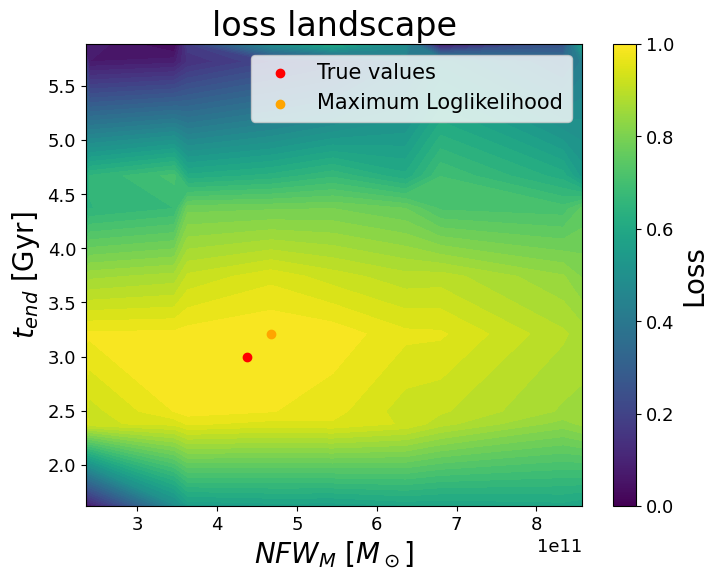

In [17]:
loss_min, min_index = jnp.min(loss), jnp.argmin(loss)
Mvir_min = Mvir_flat[jnp.argmin(loss)]
t_end_min = t_end_flat[jnp.argmin(loss)]
print(f"Minimum loss: {loss_min}, Mvir: {Mvir_min * code_units.code_mass.to(u.Msun)}, t_end: {t_end_min * code_units.code_time.to(u.Gyr)}")
loss = loss.reshape(M_tot_grid.shape)

loss_max, max_index = jnp.max(loss), jnp.argmax(loss)
Mvir_max = M_tot_grid.flatten()[max_index]
t_end_max = t_end_grid.flatten()[max_index]
print(f"Maximum loss: {loss_max}, Mvir: {Mvir_max * code_units.code_mass.to(u.Msun)}, t_end: {t_end_max * code_units.code_time.to(u.Gyr)}")


# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.contourf(M_tot_values*code_units.code_mass.to(u.Msun), t_end_values*code_units.code_time.to(u.Gyr), loss.T, levels=50, cmap="viridis")
plt.scatter(params.NFW_params.Mvir * code_units.code_mass.to(u.Msun), params.t_end * code_units.code_time.to(u.Gyr),color="red", label="True values")
# plt.scatter(Mvir_min * code_units.code_mass.to(u.Msun), t_end_min * code_units.code_time.to(u.Gyr), color="blue", label="Minimum loss")
plt.scatter(Mvir_max * code_units.code_mass.to(u.Msun), t_end_max * code_units.code_time.to(u.Gyr), color="orange", label="Maximum Loglikelihood")
plt.colorbar(label="Loss")
plt.xlabel("$NFW_{M}$ [$M_\odot$]")
plt.ylabel("$t_{end}$ [Gyr]")
plt.title("loss landscape")
plt.legend()


In [18]:
grad[0].reshape(M_tot_grid.shape).shape

(10, 10)

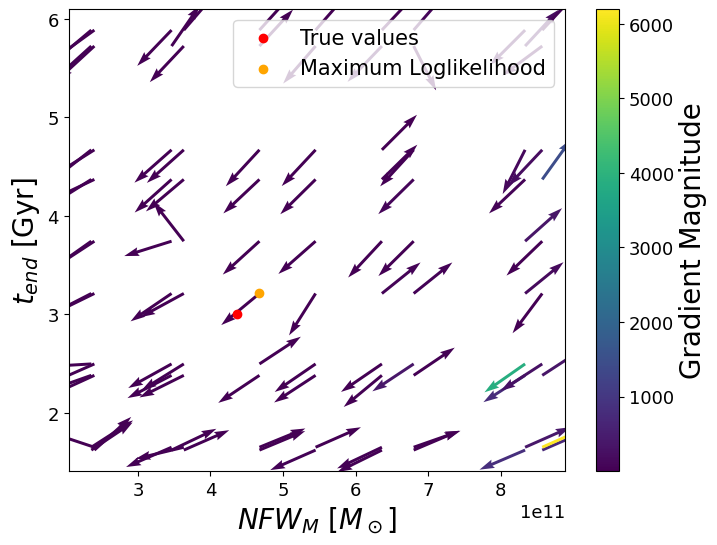

In [19]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
quiver = ax.quiver(M_tot_values * code_units.code_mass.to(u.Msun),
           t_end_values * code_units.code_time.to(u.Gyr),
           grad[0].reshape(M_tot_grid.shape)/jnp.sqrt(grad[0]**2 + grad[1]**2).reshape(M_tot_grid.shape),
           grad[1].reshape(M_tot_grid.shape)/jnp.sqrt(grad[0]**2 + grad[1]**2).reshape(M_tot_grid.shape),
           jnp.sqrt(grad[0]**2 + grad[1]**2).reshape(M_tot_grid.shape),
           scale=10, alpha=1, cmap='viridis')
ax.scatter(params.NFW_params.Mvir * code_units.code_mass.to(u.Msun), 
            params.t_end * code_units.code_time.to(u.Gyr), color="red", label="True values")
# ax.scatter(Mvir_min * code_units.code_mass.to(u.Msun),
#             t_end_min * code_units.code_time.to(u.Gyr), color="blue", label="Minimum loss")
ax.scatter(Mvir_max * code_units.code_mass.to(u.Msun),
            t_end_max * code_units.code_time.to(u.Gyr), color="orange", label="Maximum Loglikelihood")
# Add colorbar
cbar = plt.colorbar(quiver, ax=ax)
cbar.set_label('Gradient Magnitude')
ax.set_ylabel("$t_{end}$ [Gyr]")
ax.set_xlabel("$NFW_{M}$ [$M_\odot$]")
ax.legend()

## Gradient ascend

In [20]:
@jit 
def time_integration_NFWM_tend_gradascend(params, key):
    t_end = 10**params['t_end']
    M_NFW = 10**params['M_NFW']
    return time_integration_NFWM_tend_grad(M_NFW, t_end, key)

### Gradient of ln-likelihood is simple as
grad_func = jax.grad(time_integration_NFWM_tend_gradascend)

def gradient_ascent(params, learning_rates, num_iterations):
    trajectory = []
    loglike = []
    keys = []
    key = random.PRNGKey(1)  # Initialize a random key for reproducibility
    for i in range(num_iterations):
        grads = grad_func(params, key)
        params = {k: v + learning_rates[k] * grads[k] for k, v in params.items()}
        ll = time_integration_NFWM_tend_gradascend(params, key)
        _, key = random.split(key)
        trajectory.append(params)
        loglike.append(ll)
        keys.append(key)
        if i % 10 == 0:  # Print progress every 10 iterations
            arr = jnp.asarray(loglike)
            print(f"Iteration {i}, max lnlikelihood {str(arr.max())}")
    return params, trajectory, loglike, keys


lr = 1e-10
learning_rates = {
    't_end': lr,  # Learning rate for t_end
    'M_NFW': lr, 
}

best_fit = {'t_end':jnp.log10(t_end_max).item(), 'M_NFW': jnp.log10(Mvir_max).item()} 
nsteps = 10
params_final, traj, loglike_traj, keys = gradient_ascent(best_fit,learning_rates,nsteps) 

loglike_traj = jnp.asarray(loglike_traj)
id_max = jnp.argmax(loglike_traj)
params_MLE = traj[id_max]

print('t_end', 10**params_MLE['t_end']*code_units.code_time.to(u.Gyr), "Gyr")
print('M_NFW', 10**params_MLE['M_NFW']*code_units.code_mass.to(u.Msun), "Msun")

# hessian = jax.hessian(time_integration_t_endlog_gradascend)(params_MLE, keys[id_max])


# fisher_information = jnp.sqrt(-hessian['t_end']['t_end']**-1)


# physical_t_end = 10**params_MLE['t_end'] 
# print("Fisher information for t_end:", physical_t_end * code_units.code_time.to('Gyr'), "Gyr")
# print("Fisher information for t_end:", physical_t_end*jnp.log(10)*fisher_information * code_units.code_time.to('Gyr'), "Gyr")



Iteration 0, max lnlikelihood -0.00057966955
t_end 3.2105093 Gyr
M_NFW 467485200000.0 Msun


In [21]:
params_MLE

{'t_end': Array(0.02945269, dtype=float32, weak_type=True),
 'M_NFW': Array(7.669768, dtype=float32, weak_type=True)}

## Gradient descend

In [ ]:
from jaxopt import ScipyMinimize, LBFGS
import optax
import optimistix as optx
from tqdm import tqdm



# from functools import partial
# @partial(jit, static_argnames=('func','learning_rate', 'tol', 'max_iter'))
def gradient_descent_optimization(func, x_init, key, learning_rate=20, tol=0.5, max_iter=2000):
    # xlist = jnp.zeros((max_iter + 1, x_init.shape[0]))
    xlist = []
    x = x_init
    loss_list = []
    # loss_list = jnp.zeros(max_iter + 1)

    xlist.append(x)
    # xlist = xlist.at[0].set(x)  # Initialize the first element with x_init

    # ADAM optimizer
    # optimizer = optax.adam(learning_rate=learning_rate)
    # optimizer_state = optimizer.init(x)

    #SCHEDULE FREE ADAM
    # learning_rate_fn = optax.warmup_constant_schedule(peak_value=learning_rate, warmup_steps=10, init_value=0.0)
    # optimizer = optax.adam(learning_rate_fn, b1=0.)
    # optimizer = optax.contrib.schedule_free(optimizer, learning_rate_fn, b1=0.9)
    # optimizer_state = optimizer.init(x)

    #SCHEDULE FREE ADAMW
    optimizer = optax.contrib.schedule_free_adamw(learning_rate)
    optimizer_state = optimizer.init(x)


    for _ in tqdm(range(max_iter)):
        # Compute the function value and its gradient
        loss, f_grad = jax.value_and_grad(func)(x, key)
        loss_list.append(loss)
        # loss_list = loss_list.at[_].set(loss)
        
        # Update the parameter
        updates, optimizer_state = optimizer.update(f_grad, optimizer_state, x)
        x = optax.apply_updates(x, updates)
        key = random.split(key, 1)[0]  # Update the key for the next iteration
        xlist.append(x)
        # xlist = xlist.at[_ + 1].set(x)
        
        # Check convergence
        if jnp.linalg.norm(updates) < tol:
            break
    
    return x, xlist, loss_list

In [ ]:
x1, xlist, loss_list = gradient_descent_optimization(
    time_integration_for_gradient_descend, 
    jnp.array([jnp.log10(Mvir_min), jnp.log10(t_end_min)]),
    random.PRNGKey(0), 
    learning_rate=1e-2,
    tol=1e-12, 
    max_iter=200)

100%|██████████| 200/200 [02:55<00:00,  1.14it/s]


In [39]:
x1 = 10**x1  # Convert back to original scale
xlist = 10**jnp.array(xlist)  # Convert back to original scale

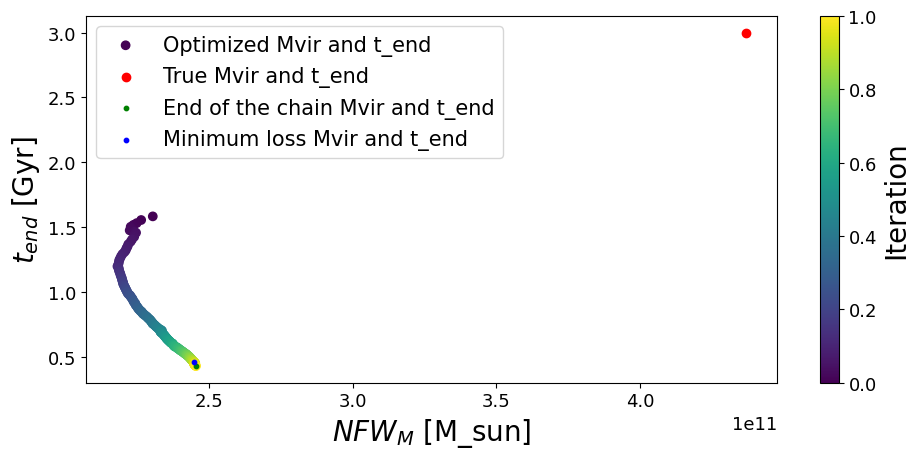

In [40]:
plt.figure(figsize=(10, 5), tight_layout=True)
plt.scatter(xlist[1:][:, 0] * code_units.code_mass.to(u.Msun),
            xlist[1:][:, 1] * code_units.code_time.to(u.Gyr), 
            c=jnp.arange(len(xlist[1:])) ,label='Optimized Mvir and t_end')
plt.scatter(params.NFW_params.Mvir * code_units.code_mass.to(u.Msun),
            params.t_end * code_units.code_time.to(u.Gyr), label='True Mvir and t_end', color='r')
plt.scatter(x1[0] * code_units.code_mass.to(u.Msun),
            x1[1] * code_units.code_time.to(u.Gyr), 
            s=10, label='End of the chain Mvir and t_end', color='g')
plt.scatter(xlist[np.argmin(loss_list)][0] * code_units.code_mass.to(u.Msun),
            xlist[np.argmin(loss_list)][1] * code_units.code_time.to(u.Gyr), 
            s=10, label='Minimum loss Mvir and t_end', color='b')
plt.xlabel("$NFW_M$ [M_sun]")
plt.ylabel("$t_{end}$ [Gyr]")
plt.colorbar(label='Iteration')
plt.legend()

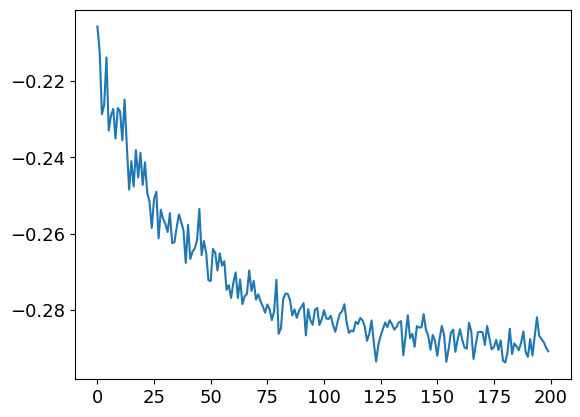

In [41]:
plt.plot(loss_list)

## NUTS

In [26]:

min_prior_t_end = params.t_end * (1/4) 
differnce_min_max_tend = params.t_end * (8/4) - min_prior_t_end

min_prior_Mvir = params.NFW_params.Mvir * (1/4)
differnce_max_min_Mvir = params.NFW_params.Mvir * (8/4) - min_prior_Mvir
@jit 
def log_prob(params, key):
    Mvir = 10**params['M_NFW']
    t_end = 10**params['t_end']
    # return jnp.exp(time_integration_NFWM_tend_grad(Mvir, t_end, key)) * jax.scipy.stats.uniform.pdf(t_end, loc=min_prior_t_end, scale=differnce_min_max_tend) * jax.scipy.stats.uniform.pdf(Mvir, loc=min_prior_Mvir, scale=differnce_max_min_Mvir)
    # Get your MMD value (assuming this is your loss/negative log-likelihood)
    minus_mmd_value = time_integration_NFWM_tend_grad(Mvir, t_end, key)
    
    # Convert MMD to log-likelihood (assuming MMD should be negated)
    log_likelihood = minus_mmd_value
    
    # Return log-posterior (log-likelihood + log-priors)
    return log_likelihood 

@jit
def prior(params):
    """Compute the log-prior for the parameters."""
    Mvir = 10**params['M_NFW']
    t_end = 10**params['t_end']
    
    # Uniform priors
    prior_Mvir = jax.scipy.stats.uniform.logpdf(Mvir, loc=min_prior_Mvir, scale=differnce_max_min_Mvir)
    prior_t_end = jax.scipy.stats.uniform.logpdf(t_end, loc=min_prior_t_end, scale=differnce_min_max_tend)
    
    return jnp.exp(prior_Mvir + prior_t_end)

@jit
def logdensity(params, ):
    """Compute the log-density of the posterior."""
    # Compute the log-likelihood
    log_likelihood = log_prob(params, key=random.PRNGKey(0))
    
    # Compute the log-prior
    log_prior = jnp.log(prior(params))
    
    # Return the log-posterior
    return log_likelihood + log_prior

def inference_loop(rng_key, kernel, initial_state, num_samples):

    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [31]:
import blackjax


inv_mass_matrix = np.array([0.5, 0.01])
step_size = 1e-3

nuts = blackjax.nuts(logdensity, step_size, inv_mass_matrix)

num_chains = 2

def inference_loop_multiple_chains(
    rng_key, kernel, initial_state, num_samples, num_chains
):

    @jax.jit
    def one_step(states, rng_key):
        keys = jax.random.split(rng_key, num_chains)
        states, _ = jax.vmap(kernel)(keys, states)
        return states, states

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

params_MLE = {'t_end': jnp.array([t_end_max, t_end_max*0.8]),
              'M_NFW': jnp.array([Mvir_max, Mvir_max*0.8])}  
initial_states = jax.vmap(nuts.init, in_axes=(0))(params_MLE)

2025-06-29 17:50:04.728334: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3022] Can't reduce memory use below 3.61GiB (3879294953 bytes) by rematerialization; only reduced to 4.63GiB (4970947314 bytes), down from 4.64GiB (4978971762 bytes) originally


In [ ]:
states = inference_loop_multiple_chains(
    random.PRNGKey(1), nuts.step, initial_states, 2_000, num_chains
)
_ = states.position["M_NFW"].block_until_ready()

In [ ]:
_

## MALA

In [32]:
import blackjax

def run_mclmc(logdensity_fn, num_steps, initial_position, key, desired_energy_variance= 5e-4):
    init_key, tune_key, run_key = jax.random.split(key, 3)

    # create an initial state for the sampler
    initial_state = blackjax.mcmc.mclmc.init(
        position=initial_position, logdensity_fn=logdensity_fn, rng_key=init_key
    )

    # build the kernel
    kernel = lambda inverse_mass_matrix : blackjax.mcmc.mclmc.build_kernel(
        logdensity_fn=logdensity_fn,
        integrator=blackjax.mcmc.integrators.isokinetic_mclachlan,
        inverse_mass_matrix=inverse_mass_matrix,
    )

    # find values for L and step_size
    (
        blackjax_state_after_tuning,
        blackjax_mclmc_sampler_params,
        _
    ) = blackjax.mclmc_find_L_and_step_size(
        mclmc_kernel=kernel,
        num_steps=num_steps,
        state=initial_state,
        rng_key=tune_key,
        diagonal_preconditioning=False,
        desired_energy_var=desired_energy_variance
    )

    # use the quick wrapper to build a new kernel with the tuned parameters

    sampling_alg = blackjax.mclmc(
        logdensity_fn,
        L=blackjax_mclmc_sampler_params.L,
        step_size=blackjax_mclmc_sampler_params.step_size,
    )

    # run the sampler
    _, samples = blackjax.util.run_inference_algorithm(
        rng_key=run_key,
        initial_state=blackjax_state_after_tuning,
        inference_algorithm=sampling_alg,
        num_steps=num_steps,
        progress_bar=True,
    )

    return samples, blackjax_state_after_tuning, blackjax_mclmc_sampler_params, run_key

In [33]:
params_MLE = {'t_end': jnp.array([t_end_max, ]),
              'M_NFW': jnp.array([Mvir_max, ])}  
samples, initial_state, params, chain_key = run_mclmc(
    logdensity,
    num_steps=1_000,
    initial_position=params_MLE,
    key=random.PRNGKey(42))

TypeCheckError: Type-check error whilst checking the parameters of odisseo.integrators.leapfrog.
The problem arose whilst typechecking parameter 'dt'.
Actual value: f32[1]
Expected type: <class 'Shaped[Array, '']'>.
----------------------
Called with parameters: {
  'state': f32[1,2,3],
  'mass': f32[1],
  'dt': f32[1],
  'config':
  SimulationConfig(
    N_particles=1,
    dimensions=3,
    return_snapshots=False,
    num_snapshots=500,
    fixed_timestep=True,
    num_timesteps=1000,
    softening=np.float64(1.0000000000000003e-05),
    integrator=0,
    diffrax_solver=0,
    acceleration_scheme=2,
    batch_size=10000,
    double_map=False,
    external_accelerations=(0, 2, 3),
    differentation_mode=1,
    num_checkpoints=100,
    progress_bar=False
  ),
  'params':
  SimulationParams(
    G=f32[],
    t_end=f32[1],
    Plummer_params=PlummerParams(a=f32[], Mtot=f32[]),
    NFW_params=NFWParams(Mvir=f32[1], r_s=f32[]),
    PointMass_params=PointMassParams(M=weak_f32[]),
    MN_params=MNParams(M=f32[], a=f32[], b=f32[]),
    PSP_params=PSPParams(M=weak_f32[], alpha=weak_f32[], r_c=f32[]),
    Logarithmic_Params=LogarithmicParams(v0=weak_f32[], q=weak_f32[])
  )
}
Parameter annotations: (state: jax.Array, mass: jax.Array, dt: Shaped[Array, ''], config: odisseo.option_classes.SimulationConfig, params: odisseo.option_classes.SimulationParams) -> Any.


## Langevine sampling

In [22]:
min_prior_t_end = params.t_end * (1/4) 
differnce_min_max_tend = params.t_end * (8/4) - min_prior_t_end

min_prior_Mvir = params.NFW_params.Mvir * (1/4)
differnce_max_min_Mvir = params.NFW_params.Mvir * (8/4) - min_prior_Mvir
@jit 
def time_integration_for_langevin(params, key):
    Mvir = 10**params['M_NFW']
    t_end = 10**params['t_end']
    # return jnp.exp(time_integration_NFWM_tend_grad(Mvir, t_end, key)) * jax.scipy.stats.uniform.pdf(t_end, loc=min_prior_t_end, scale=differnce_min_max_tend) * jax.scipy.stats.uniform.pdf(Mvir, loc=min_prior_Mvir, scale=differnce_max_min_Mvir)
    # Get your MMD value (assuming this is your loss/negative log-likelihood)
    minus_mmd_value = time_integration_NFWM_tend_grad(Mvir, t_end, key)
    
    # Convert MMD to log-likelihood (assuming MMD should be negated)
    log_likelihood = minus_mmd_value
    
    # Add log priors
    log_prior_t_end = jax.scipy.stats.uniform.logpdf(t_end, loc=min_prior_t_end, scale=differnce_min_max_tend)
    log_prior_Mvir = jax.scipy.stats.uniform.logpdf(Mvir, loc=min_prior_Mvir, scale=differnce_max_min_Mvir)
    
    # Return log-posterior (log-likelihood + log-priors)
    return log_likelihood + log_prior_t_end + log_prior_Mvir

In [28]:
from tqdm import tqdm 

def langevin_sampler(initial_params, num_samples, step_size, rng_key):
    samples = []
    params = initial_params
    for i in tqdm(range(num_samples)):
        grads = jax.jacfwd(time_integration_for_langevin)(params, rng_key)
        noise = jax.random.normal(rng_key, shape=jnp.array(list(params.values())).shape)
        params = {k: v + 0.5 * step_size[k] * grads[k] + jnp.sqrt(step_size[k]) * noise[idx] for idx, (k, v) in enumerate(params.items())}
        samples.append(params)
        rng_key, _ = jax.random.split(rng_key)
    return samples

In [37]:
lr = 1e-15
learning_rates = {'t_end': lr,
                  'M_NFW': lr}

In [38]:
params_MLE = {'t_end': jnp.log10(t_end_max),
              'M_NFW': jnp.log10(Mvir_max)}  
rng_key = random.PRNGKey(42)
out_samps = langevin_sampler(params_MLE, 1000, learning_rates, rng_key)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [05:49<00:00,  2.86it/s]


/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/chainconsumer/plotter.py:861: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(base.extents[p2])
/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:901: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


IndexError: index 0 is out of bounds for axis 0 with size 0

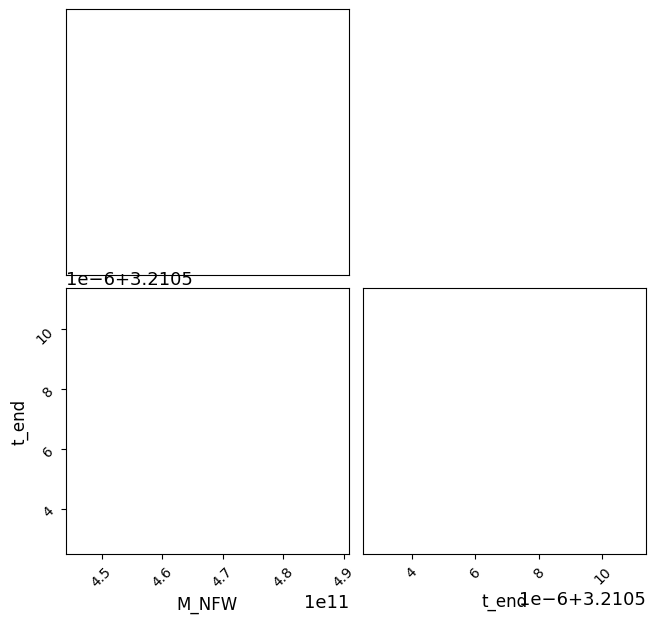

In [39]:
from chainconsumer import Chain, ChainConsumer, Truth
import pandas as pd

df = pd.DataFrame(out_samps, columns=['M_NFW', 't_end'])
df = df.astype(float)  # Ensure all values are float

df = df[np.isfinite(df).all(axis=1)]
df = df.dropna() # Drop any rows with NaN values
df['M_NFW'] = 10**df['M_NFW'] * code_units.code_mass.to(u.Msun)
df['M_NFW'] = df['M_NFW'].astype(float)
df['t_end'] = 10**df['t_end'] * code_units.code_time.to(u.Gyr)
df['t_end'] = df['t_end'].astype(float) 
c = ChainConsumer()
c.add_chain(Chain(samples=df, name='Langevin samples'))
c.add_truth(Truth(location={'M_NFW': params.NFW_params.Mvir* code_units.code_mass.to(u.Msun), 
                            't_end': params.t_end* code_units.code_time.to(u.Gyr)}), )
fig = c.plotter.plot()

In [32]:
import xarray as xr
import arviz as az


df["chain"] = 0
df["draw"] = np.arange(len(df), dtype=int)
df = df.set_index(["chain", "draw"])
xdata = xr.Dataset.from_dataframe(df)

idata = az.InferenceData(posterior=xdata)
idata

Inference data with groups:
	> posterior

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


               mean            sd        hdi_3%       hdi_97%     mcse_mean  \
M_NFW  4.959281e+11  2.198386e+10  4.666052e+11  5.412471e+11  1.289171e+10   
t_end  2.979000e+00  1.570000e-01  2.666000e+00  3.216000e+00  1.300000e-01   

            mcse_sd  ess_bulk  ess_tail  r_hat  
M_NFW  6.053421e+09       4.0      34.0    NaN  
t_end  3.400000e-02       1.0      13.0    NaN  


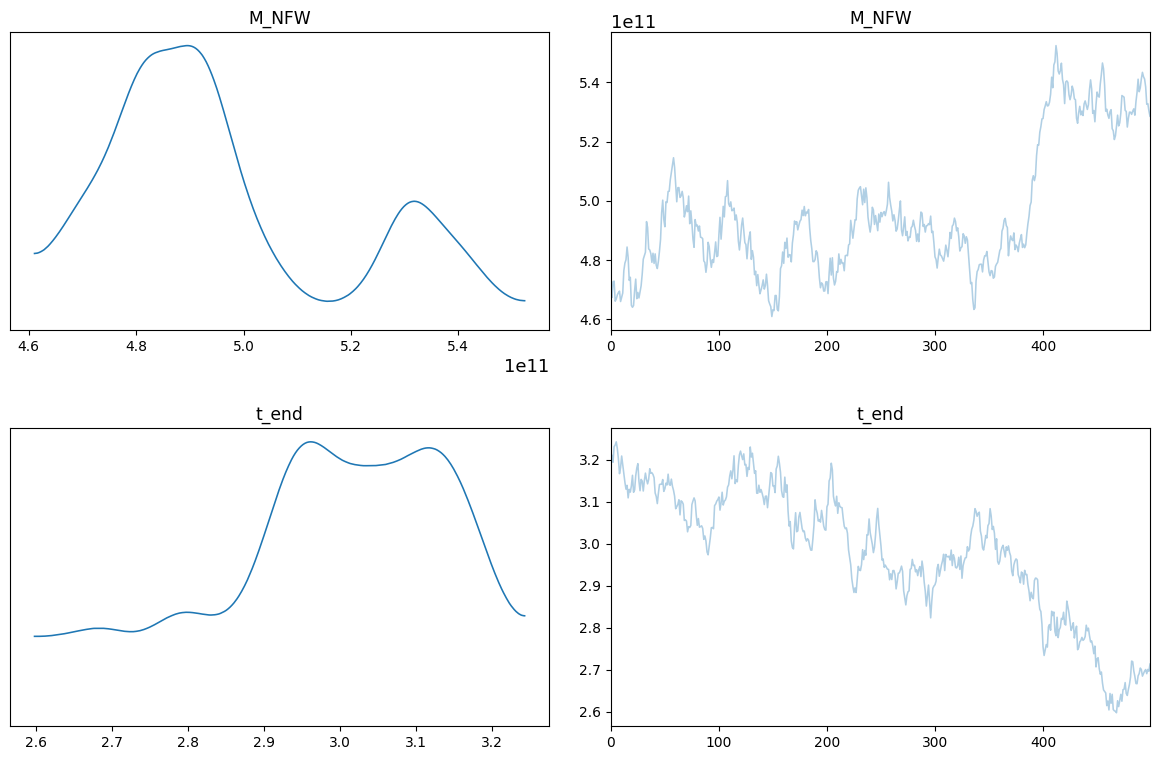

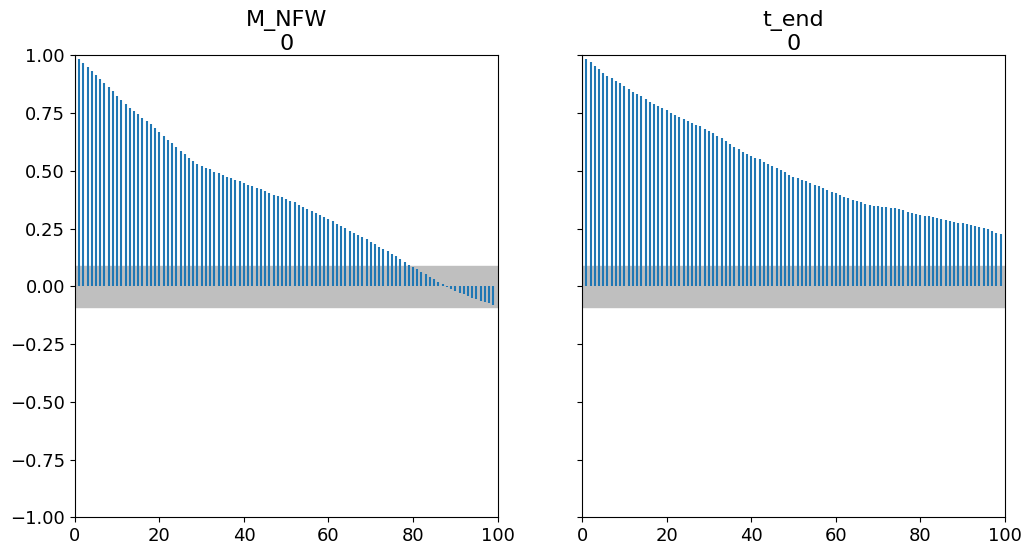

Effective Sample Size:
<xarray.Dataset> Size: 16B
Dimensions:  ()
Data variables:
    M_NFW    float64 8B 4.372
    t_end    float64 8B 1.439
Monte Carlo Standard Error:
<xarray.Dataset> Size: 16B
Dimensions:  ()
Data variables:
    M_NFW    float64 8B 1.289e+10
    t_end    float64 8B 0.1303


In [33]:
# Summary statistics including R-hat, ESS, etc.
summary = az.summary(idata)
print(summary)

# Plot trace plots to visualize convergence
az.plot_trace(idata, figsize=(12, 8))
plt.tight_layout()
plt.show()

# Plot autocorrelation
az.plot_autocorr(idata, figsize=(12, 6))
plt.show()

# Effective sample size
ess = az.ess(idata)
print("Effective Sample Size:")
print(ess)

# Monte Carlo Standard Error
mcse = az.mcse(idata)
print("Monte Carlo Standard Error:")
print(mcse)

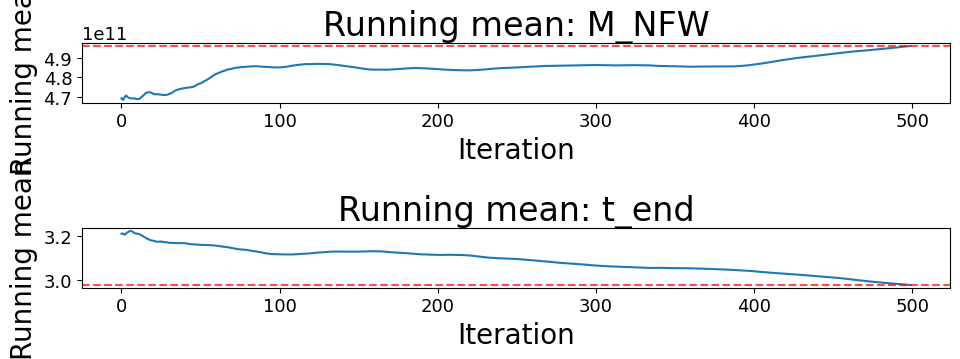

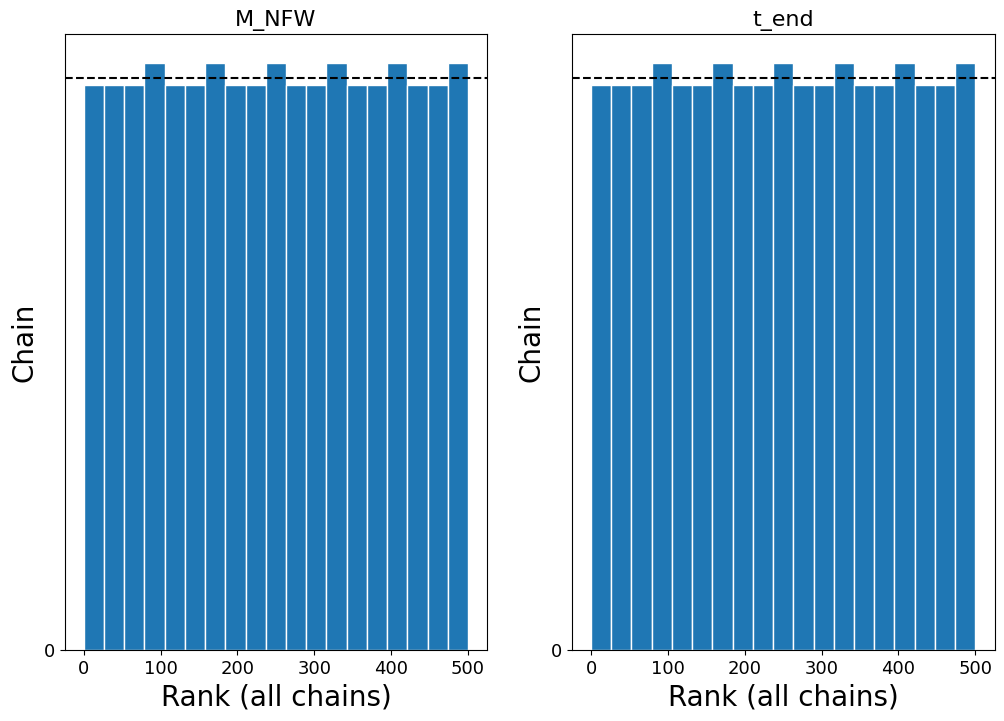

In [34]:
# Plot running means to identify burn-in
def plot_running_mean(idata, var_names=None):
    if var_names is None:
        var_names = list(idata.posterior.data_vars)
    
    fig, axes = plt.subplots(len(var_names), 1, figsize=(10, 2*len(var_names)))
    if len(var_names) == 1:
        axes = [axes]
    
    for i, var in enumerate(var_names):
        samples = idata.posterior[var].values.flatten()
        running_mean = np.cumsum(samples) / np.arange(1, len(samples) + 1)
        
        axes[i].plot(running_mean)
        axes[i].set_title(f'Running mean: {var}')
        axes[i].set_xlabel('Iteration')
        axes[i].set_ylabel('Running mean')
        
        # Add horizontal line at final mean
        axes[i].axhline(y=np.mean(samples), color='r', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

plot_running_mean(idata)

# Alternative: Use ArviZ's built-in rank plot
az.plot_rank(idata, figsize=(12, 8))
plt.show()

In [35]:
# Calculate autocorrelation time for each parameter
def autocorr_time(x, max_lag=None):
    """Calculate autocorrelation time"""
    if max_lag is None:
        max_lag = len(x) // 4
    
    # Calculate autocorrelation function
    autocorr = np.correlate(x - np.mean(x), x - np.mean(x), mode='full')
    autocorr = autocorr[autocorr.size // 2:]
    autocorr = autocorr / autocorr[0]
    
    # Find where autocorrelation drops below 1/e
    try:
        tau_int = np.where(autocorr < 1/np.e)[0][0]
    except IndexError:
        tau_int = len(autocorr) - 1
    
    return tau_int

# Calculate autocorrelation times
autocorr_times = {}
for var in idata.posterior.data_vars:
    samples = idata.posterior[var].values.flatten()
    tau = autocorr_time(samples)
    autocorr_times[var] = tau
    print(f"Autocorrelation time for {var}: {tau}")

# Recommended thinning interval (2-3 times the autocorrelation time)
max_tau = max(autocorr_times.values())
recommended_thin = int(2 * max_tau)
print(f"\nRecommended thinning interval: {recommended_thin}")

Autocorrelation time for M_NFW: 52
Autocorrelation time for t_end: 66

Recommended thinning interval: 132


In [36]:
# Determine burn-in based on visual inspection and convergence
# Typically 10-50% of samples, or when running mean stabilizes
burn_in = 500  # Adjust based on your trace plots

# Apply burn-in and thinning
def apply_burn_in_and_thin(idata, burn_in=0, thin=1):
    """Apply burn-in and thinning to InferenceData"""
    posterior_thinned = idata.posterior.isel(draw=slice(burn_in, None, thin))
    
    # Create new InferenceData with thinned samples
    idata_thinned = az.InferenceData(posterior=posterior_thinned)
    return idata_thinned

# Apply burn-in and thinning
idata_clean = apply_burn_in_and_thin(idata, burn_in=burn_in, thin=recommended_thin)

print(f"Original samples: {idata.posterior.dims['draw']}")
print(f"After burn-in and thinning: {idata_clean.posterior.dims['draw']}")

Original samples: 500
After burn-in and thinning: 0


/tmp/ipykernel_2886039/3382698462.py:17: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"Original samples: {idata.posterior.dims['draw']}")
/tmp/ipykernel_2886039/3382698462.py:18: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"After burn-in and thinning: {idata_clean.posterior.dims['draw']}")


## Multiple chains

In [258]:
# params_MLE_for_vmap = jnp.stack( jnp.array([jnp.log10(jnp.array([Mvir_max, t_end_max])) for i in range(2)]) ) 

argsort_loglike_traj = jnp.argsort(loglike_traj, descending=True)

params_MLE_0 = jnp.array(list(traj[argsort_loglike_traj[0]].values())[::-1] ) #need to flip to have first M_NFW and then t_end
params_MLE_1 = jnp.array(list(traj[argsort_loglike_traj[1]].values())[::-1] )
params_MLE_2 = jnp.array(list(traj[argsort_loglike_traj[2]].values())[::-1] )
params_MLE_3 = jnp.array(list(traj[argsort_loglike_traj[3]].values())[::-1] )
params_MLE_for_vmap = jnp.stack(jnp.array([params_MLE_0, params_MLE_1, params_MLE_2, params_MLE_3]))
rng_keys_vmap = random.split(rng_key, len(params_MLE_for_vmap))

def vmap_langevin_sampler(params_MLE, rng_keys):
    params = {'M_NFW': params_MLE[0],
              't_end': params_MLE[1]}
    return langevin_sampler(params, 2_000, learning_rates, rng_keys)

out_samps_vmap = jax.vmap(vmap_langevin_sampler, in_axes=(0, 0))(params_MLE_for_vmap, rng_keys_vmap)


100%|██████████| 2000/2000 [21:44<00:00,  1.53it/s]


In [259]:
# Method 1: Using stack and unstack
def array_to_dataframe(arr):
    # Create MultiIndex for the reshaped data
    n_draws, n_params, n_chains = arr.shape
    
    # Reshape to (draws * chains, parameters)
    reshaped = arr.transpose(0, 2, 1).reshape(-1, n_params)
    
    # Create the multi-index
    draw_idx = np.tile(np.arange(n_draws), n_chains)
    chain_idx = np.repeat(np.arange(n_chains), n_draws)
    
    # Create DataFrame
    df = pd.DataFrame(reshaped, columns=['M_NFW', 't_end'])
    df['chain'] = chain_idx
    df['draw'] = draw_idx
    
    # Set the multi-index
    df = df.set_index(['chain', 'draw'])
    
    return df

df_multiple_chains = array_to_dataframe(jnp.array([list(i.values()) for i in out_samps_vmap]))
df_multiple_chains = df_multiple_chains.astype(float)  # Ensure all values are float
df_multiple_chains['M_NFW'] = 10**df_multiple_chains['M_NFW'] * code_units.code_mass.to(u.Msun)
df_multiple_chains['t_end'] = 10**df_multiple_chains['t_end'] * code_units.code_time.to(u.Gyr)
xdata_multiple_chains = xr.Dataset.from_dataframe(df_multiple_chains)

idata = az.InferenceData(posterior=xdata_multiple_chains)
idata

Inference data with groups:
	> posterior

Parameter M_NFW in chain Langevin samples is not constrained
Parameter t_end in chain Langevin samples is not constrained


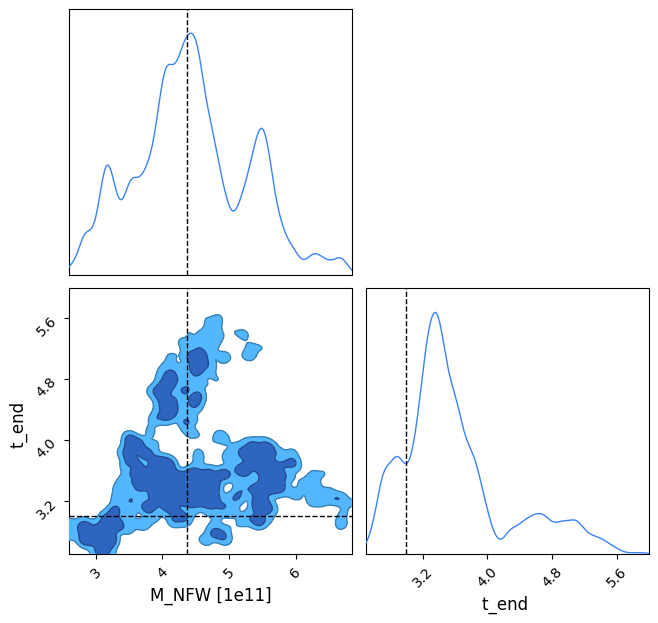

In [260]:
c = ChainConsumer()
c.add_chain(Chain(samples=df_multiple_chains, name='Langevin samples'))
c.add_truth(Truth(location={'M_NFW': params.NFW_params.Mvir* code_units.code_mass.to(u.Msun), 
                            't_end': params.t_end* code_units.code_time.to(u.Gyr)}), )
fig = c.plotter.plot()

               mean            sd        hdi_3%       hdi_97%     mcse_mean  \
M_NFW  4.440997e+11  8.390084e+10  2.796521e+11  5.780270e+11  9.229178e+08   
t_end  3.597000e+00  6.640000e-01  2.651000e+00  5.083000e+00  1.170000e-01   

            mcse_sd  ess_bulk  ess_tail  r_hat  
M_NFW  1.313386e+10    8211.0    8353.0   1.14  
t_end  1.290000e-01   14230.0    8626.0   1.29  


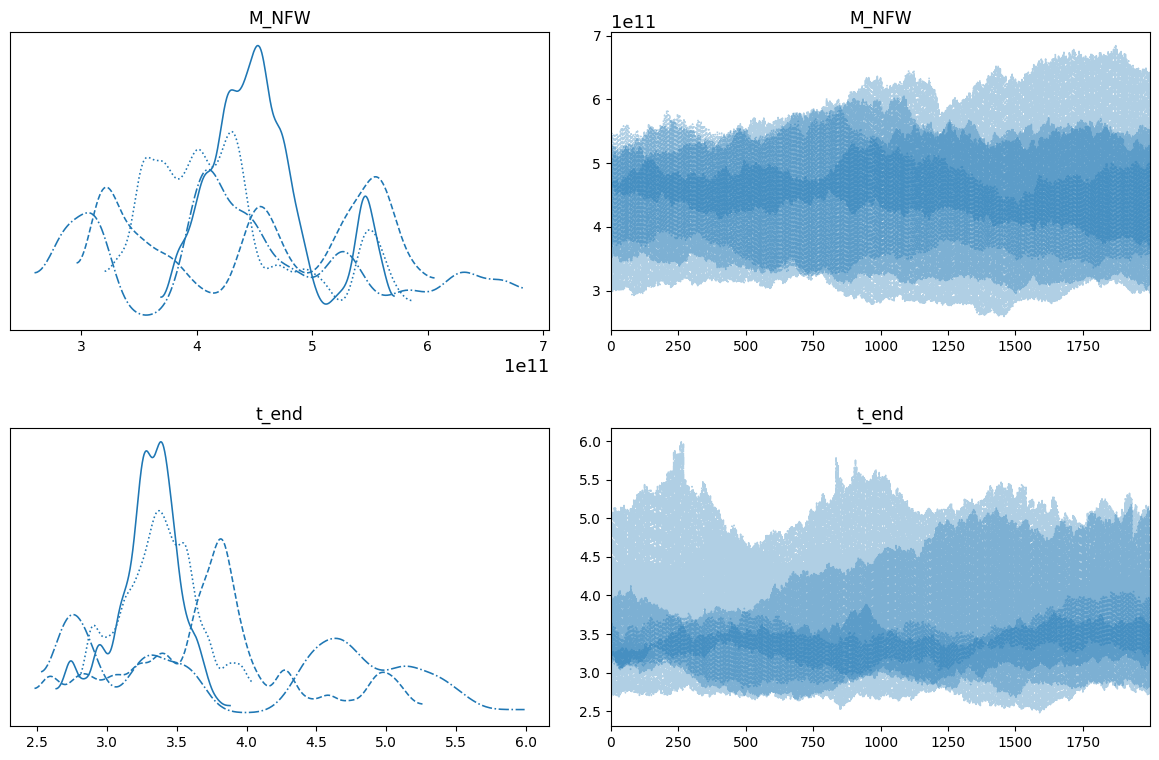

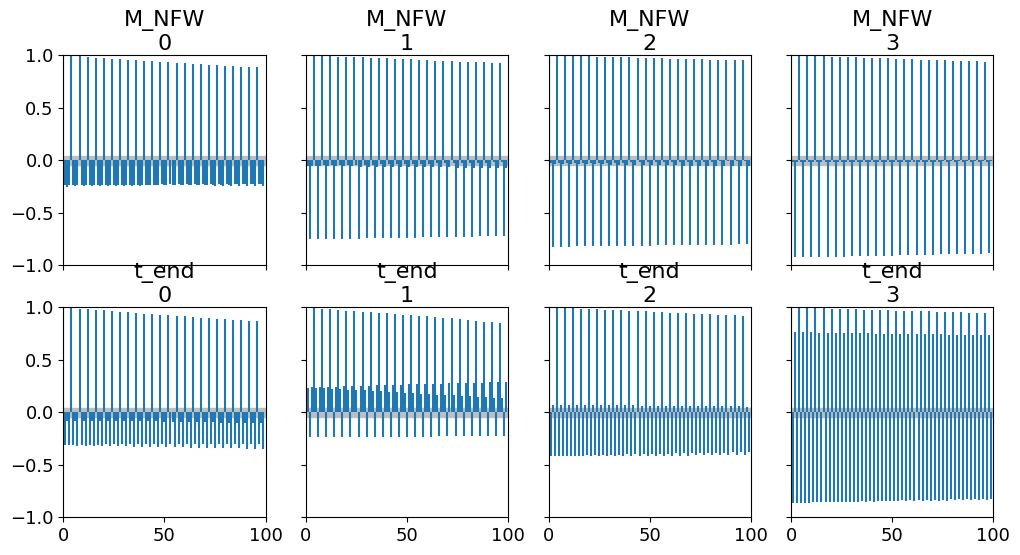

Effective Sample Size:
<xarray.Dataset> Size: 16B
Dimensions:  ()
Data variables:
    M_NFW    float64 8B 8.211e+03
    t_end    float64 8B 1.423e+04
Monte Carlo Standard Error:
<xarray.Dataset> Size: 16B
Dimensions:  ()
Data variables:
    M_NFW    float64 8B 9.229e+08
    t_end    float64 8B 0.117


In [261]:
# Summary statistics including R-hat, ESS, etc.
summary = az.summary(idata)
print(summary)

# Plot trace plots to visualize convergence
az.plot_trace(idata, figsize=(12, 8))
plt.tight_layout()
plt.show()

# Plot autocorrelation
az.plot_autocorr(idata, figsize=(12, 6))
plt.show()

# Effective sample size
ess = az.ess(idata)
print("Effective Sample Size:")
print(ess)

# Monte Carlo Standard Error
mcse = az.mcse(idata)
print("Monte Carlo Standard Error:")
print(mcse)

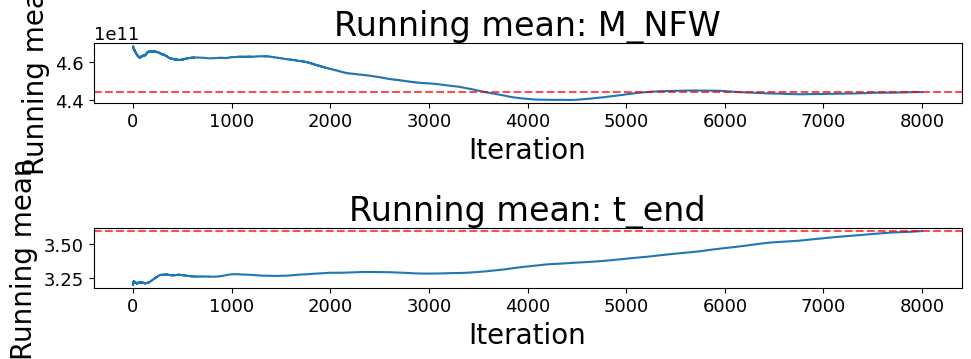

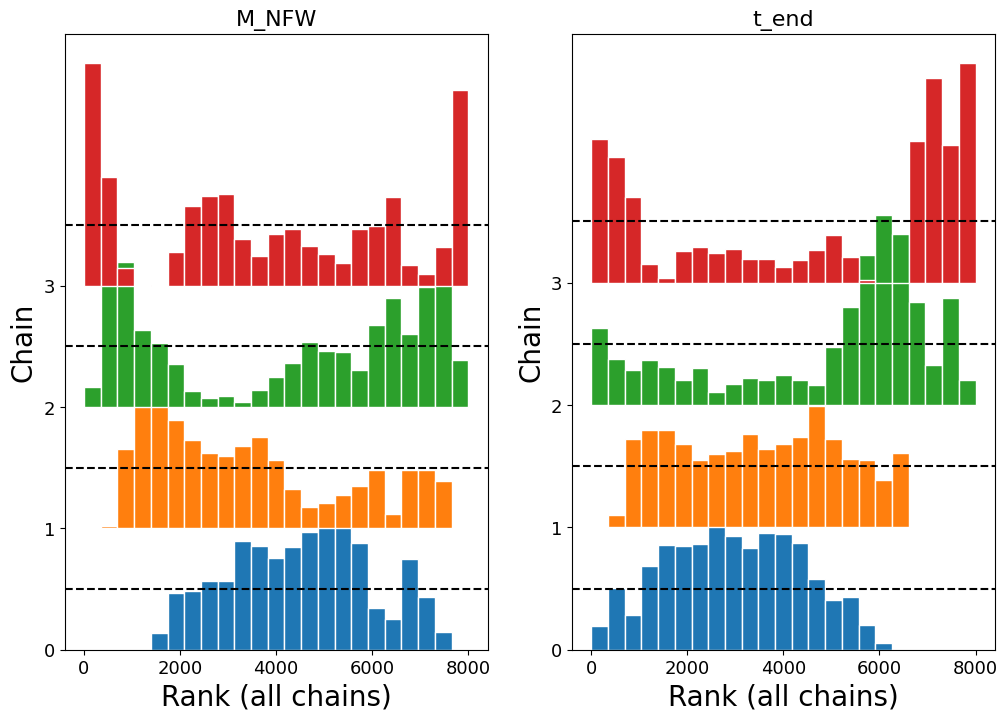

In [262]:
# Plot running means to identify burn-in
def plot_running_mean(idata, var_names=None):
    if var_names is None:
        var_names = list(idata.posterior.data_vars)
    
    fig, axes = plt.subplots(len(var_names), 1, figsize=(10, 2*len(var_names)))
    if len(var_names) == 1:
        axes = [axes]
    
    for i, var in enumerate(var_names):
        samples = idata.posterior[var].values.flatten()
        running_mean = np.cumsum(samples) / np.arange(1, len(samples) + 1)
        
        axes[i].plot(running_mean)
        axes[i].set_title(f'Running mean: {var}')
        axes[i].set_xlabel('Iteration')
        axes[i].set_ylabel('Running mean')
        
        # Add horizontal line at final mean
        axes[i].axhline(y=np.mean(samples), color='r', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

plot_running_mean(idata)

# Alternative: Use ArviZ's built-in rank plot
az.plot_rank(idata, figsize=(12, 8))
plt.show()

In [269]:
import pickle

# Save
with open('samples.pkl', 'wb') as f:
    pickle.dump(out_samps_vmap, f)

# Load
with open('samples.pkl', 'rb') as f:
    loaded_samples = pickle.load(f)

In [263]:
# Calculate autocorrelation time for each parameter
def autocorr_time(x, max_lag=None):
    """Calculate autocorrelation time"""
    if max_lag is None:
        max_lag = len(x) // 4
    
    # Calculate autocorrelation function
    autocorr = np.correlate(x - np.mean(x), x - np.mean(x), mode='full')
    autocorr = autocorr[autocorr.size // 2:]
    autocorr = autocorr / autocorr[0]
    
    # Find where autocorrelation drops below 1/e
    try:
        tau_int = np.where(autocorr < 1/np.e)[0][0]
    except IndexError:
        tau_int = len(autocorr) - 1
    
    return tau_int

# Calculate autocorrelation times
autocorr_times = {}
for var in idata.posterior.data_vars:
    samples = idata.posterior[var].values.flatten()
    tau = autocorr_time(samples)
    autocorr_times[var] = tau
    print(f"Autocorrelation time for {var}: {tau}")

# Recommended thinning interval (2-3 times the autocorrelation time)
max_tau = max(autocorr_times.values())
recommended_thin = int(2 * max_tau)
print(f"\nRecommended thinning interval: {recommended_thin}")

Autocorrelation time for M_NFW: 1
Autocorrelation time for t_end: 1

Recommended thinning interval: 2


In [264]:
# Determine burn-in based on visual inspection and convergence
# Typically 10-50% of samples, or when running mean stabilizes
burn_in = 200  # Adjust based on your trace plots

# Apply burn-in and thinning
def apply_burn_in_and_thin(idata, burn_in=0, thin=1):
    """Apply burn-in and thinning to InferenceData"""
    posterior_thinned = idata.posterior.isel(draw=slice(burn_in, None, thin))
    
    # Create new InferenceData with thinned samples
    idata_thinned = az.InferenceData(posterior=posterior_thinned)
    return idata_thinned

# Apply burn-in and thinning
idata_clean = apply_burn_in_and_thin(idata, burn_in=burn_in, thin=recommended_thin)

print(f"Original samples: {idata.posterior.dims['draw']}")
print(f"After burn-in and thinning: {idata_clean.posterior.dims['draw']}")

Original samples: 2000
After burn-in and thinning: 900


/tmp/ipykernel_4125858/3718018976.py:17: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"Original samples: {idata.posterior.dims['draw']}")
/tmp/ipykernel_4125858/3718018976.py:18: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"After burn-in and thinning: {idata_clean.posterior.dims['draw']}")


In [255]:
# Complete diagnostic analysis
def analyze_chains(idata, burn_in=0, thin=1):
    """Comprehensive chain analysis"""
    
    # Apply burn-in and thinning if needed
    if burn_in > 0 or thin > 1:
        idata_clean = idata.sel(draw=slice(burn_in, None, thin))
    else:
        idata_clean = idata
    
    print("=== CHAIN DIAGNOSTICS ===")
    
    # 1. Basic summary with R-hat
    summary = az.summary(idata_clean, hdi_prob=0.94)
    print("\nSummary Statistics:")
    print(summary)
    
    # 2. Convergence diagnostics
    print(f"\nR-hat values (should be < 1.1):")
    rhat = az.rhat(idata_clean)
    for var in rhat.data_vars:
        print(f"{var}: {float(rhat[var].values):.4f}")
    
    # 3. Effective sample size
    print(f"\nEffective Sample Size:")
    ess_bulk = az.ess(idata_clean, method="bulk")
    ess_tail = az.ess(idata_clean, method="tail")
    for var in ess_bulk.data_vars:
        print(f"{var} - Bulk: {int(ess_bulk[var].values)}, Tail: {int(ess_tail[var].values)}")
    
    # 4. Monte Carlo Standard Error
    print(f"\nMonte Carlo Standard Error:")
    mcse = az.mcse(idata_clean)
    for var in mcse.data_vars:
        print(f"{var}: {float(mcse[var].values):.6f}")
    
    return idata_clean, summary

# Run analysis
idata_clean, summary = analyze_chains(idata, burn_in=200, thin=2)

=== CHAIN DIAGNOSTICS ===

Summary Statistics:
               mean            sd        hdi_3%       hdi_97%     mcse_mean  \
M_NFW  4.257510e+11  8.633500e+10  2.770835e+11  5.905088e+11  1.964208e+09   
t_end  3.558000e+00  5.960000e-01  2.643000e+00  4.759000e+00  1.500000e-02   

            mcse_sd  ess_bulk  ess_tail  r_hat  
M_NFW  1.626601e+10    1820.0     940.0   1.26  
t_end  1.100000e-01    1472.0     965.0   1.29  

R-hat values (should be < 1.1):
M_NFW: 1.2614
t_end: 1.2928

Effective Sample Size:
M_NFW - Bulk: 1819, Tail: 939
t_end - Bulk: 1472, Tail: 964

Monte Carlo Standard Error:
M_NFW: 1964207817.417377
t_end: 0.015335


In [256]:
def detect_burn_in(samples, method='gelman_rubin', threshold=1.1):
    """
    Detect burn-in period using various methods
    
    Parameters:
    -----------
    samples : array
        MCMC samples (chains, draws, parameters)
    method : str
        Method to use: 'gelman_rubin', 'geweke', 'running_mean'
    threshold : float
        Convergence threshold
    """
    
    if method == 'gelman_rubin':
        # Use R-hat to detect convergence
        burn_in = 0
        for i in range(10, samples.shape[1], 10):  # Check every 10 iterations
            subset = samples[:, :i, :]
            rhat = compute_rhat(subset)
            if np.all(rhat < threshold):
                burn_in = i
                break
        return burn_in
    
    elif method == 'running_mean':
        # Detect when running mean stabilizes
        burn_ins = []
        for param in range(samples.shape[2]):
            param_samples = samples[:, :, param].flatten()
            running_mean = np.cumsum(param_samples) / np.arange(1, len(param_samples) + 1)
            
            # Find where relative change becomes small
            rel_change = np.abs(np.diff(running_mean) / running_mean[:-1])
            stable_idx = np.where(rel_change < 0.01)[0]
            
            if len(stable_idx) > 0:
                burn_ins.append(stable_idx[0])
            else:
                burn_ins.append(len(param_samples) // 4)  # Default to 25%
        
        return max(burn_ins)
    
    elif method == 'geweke':
        # Geweke diagnostic
        burn_ins = []
        for param in range(samples.shape[2]):
            param_samples = samples.reshape(-1, samples.shape[2])[:, param]
            
            # Compare first 10% with last 50%
            n = len(param_samples)
            first_part = param_samples[:n//10]
            last_part = param_samples[n//2:]
            
            # Z-score test
            z_score = (np.mean(first_part) - np.mean(last_part)) / np.sqrt(np.var(first_part)/len(first_part) + np.var(last_part)/len(last_part))
            
            # If |z| > 2, we haven't converged yet
            if abs(z_score) > 2:
                burn_ins.append(n//4)  # Conservative estimate
            else:
                burn_ins.append(n//10)
        
        return max(burn_ins)

def compute_rhat(samples):
    """Compute R-hat statistic for convergence assessment"""
    n_chains, n_draws, n_params = samples.shape
    
    rhats = []
    for param in range(n_params):
        # Between-chain variance
        chain_means = np.mean(samples[:, :, param], axis=1)
        B = n_draws * np.var(chain_means, ddof=1)
        
        # Within-chain variance
        chain_vars = np.var(samples[:, :, param], axis=1, ddof=1)
        W = np.mean(chain_vars)
        
        # Marginal posterior variance
        var_plus = ((n_draws - 1) / n_draws) * W + (1 / n_draws) * B
        
        # R-hat
        rhat = np.sqrt(var_plus / W)
        rhats.append(rhat)
    
    return np.array(rhats)

# Apply burn-in detection
samples_array = idata.posterior.to_array().values.transpose(1, 2, 0)  # (chains, draws, params)
burn_in = detect_burn_in(samples_array, method='running_mean')
print(f"Detected burn-in period: {burn_in}")

Detected burn-in period: 0


In [257]:
def compute_autocorr_time(x, max_lag=None, c=5):
    """
    Compute integrated autocorrelation time
    
    Parameters:
    -----------
    x : array
        Time series data
    max_lag : int
        Maximum lag to consider
    c : int
        Automatic windowing constant
    """
    if max_lag is None:
        max_lag = len(x) // 4
    
    # Compute autocorrelation function
    n = len(x)
    x_centered = x - np.mean(x)
    
    # Use FFT for efficiency
    f = np.fft.fft(x_centered, 2*n-1)
    autocorr = np.fft.ifft(f * np.conj(f))[:n].real
    autocorr = autocorr / autocorr[0]
    
    # Automatic windowing
    tau_int = 1 + 2 * np.cumsum(autocorr[1:max_lag])
    
    # Find cutoff using automatic windowing
    auto_window = np.arange(1, max_lag) >= c * tau_int[:max_lag-1]
    if np.any(auto_window):
        cutoff = np.where(auto_window)[0][0]
        return tau_int[cutoff]
    else:
        return tau_int[-1]

def determine_thinning(idata, target_ess=100):
    """
    Determine optimal thinning interval
    
    Parameters:
    -----------
    idata : InferenceData
        ArviZ InferenceData object
    target_ess : int
        Target effective sample size
    """
    autocorr_times = {}
    
    for var in idata.posterior.data_vars:
        var_data = idata.posterior[var].values
        
        if len(var_data.shape) == 2:  # (chains, draws)
            # Compute for each chain and take maximum
            chain_taus = []
            for chain in range(var_data.shape[0]):
                tau = compute_autocorr_time(var_data[chain])
                chain_taus.append(tau)
            autocorr_times[var] = max(chain_taus)
        else:
            # Flatten all chains
            flattened = var_data.flatten()
            autocorr_times[var] = compute_autocorr_time(flattened)
    
    print("Autocorrelation times:")
    for var, tau in autocorr_times.items():
        print(f"  {var}: {tau:.2f}")
    
    # Recommended thinning interval
    max_tau = max(autocorr_times.values())
    thin_interval = max(1, int(2 * max_tau))  # 2x autocorr time
    
    # Check if we'll have enough samples
    n_samples_after_thin = idata.posterior.dims['draw'] // thin_interval
    n_chains = idata.posterior.dims['chain']
    total_ess = n_samples_after_thin * n_chains
    
    if total_ess < target_ess:
        print(f"Warning: After thinning by {thin_interval}, effective sample size will be {total_ess}, which is less than target {target_ess}")
        # Reduce thinning to meet target
        thin_interval = max(1, idata.posterior.dims['draw'] * n_chains // target_ess)
    
    print(f"Recommended thinning interval: {thin_interval}")
    print(f"Max autocorrelation time: {max_tau:.2f}")
    
    return thin_interval, autocorr_times

# Apply thinning determination
thin_interval, autocorr_times = determine_thinning(idata, target_ess=200)

Autocorrelation times:
  M_NFW: 490.91
  t_end: 122.50
Recommended thinning interval: 30
Max autocorrelation time: 490.91


/tmp/ipykernel_4125858/3947190153.py:74: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_samples_after_thin = idata.posterior.dims['draw'] // thin_interval
/tmp/ipykernel_4125858/3947190153.py:75: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_chains = idata.posterior.dims['chain']
/tmp/ipykernel_4125858/3947190153.py:81: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  thin_interval = max(1, 

## Microcanonical Langevine MCMC

In [41]:
import matplotlib.pyplot as plt

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.size"] = 19

import jax
import blackjax
import numpy as np
import jax.numpy as jnp
from datetime import date
import numpyro
import numpyro.distributions as dist

from numpyro.infer.util import initialize_model

rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))

In [44]:
def run_mclmc(logdensity_fn, num_steps, initial_position, key, transform, desired_energy_variance= 5e-4):
    init_key, tune_key, run_key = jax.random.split(key, 3)

    # create an initial state for the sampler
    initial_state = blackjax.mcmc.mclmc.init(
        position=initial_position, logdensity_fn=logdensity_fn, rng_key=init_key
    )

    # build the kernel
    kernel = lambda inverse_mass_matrix : blackjax.mcmc.mclmc.build_kernel(
        logdensity_fn=logdensity_fn,
        integrator=blackjax.mcmc.integrators.isokinetic_mclachlan,
        inverse_mass_matrix=inverse_mass_matrix,
    )

    # find values for L and step_size
    (
        blackjax_state_after_tuning,
        blackjax_mclmc_sampler_params,
        _
    ) = blackjax.mclmc_find_L_and_step_size(
        mclmc_kernel=kernel,
        num_steps=num_steps,
        state=initial_state,
        rng_key=tune_key,
        diagonal_preconditioning=False,
        desired_energy_var=desired_energy_variance
    )

    # use the quick wrapper to build a new kernel with the tuned parameters
    sampling_alg = blackjax.mclmc(
        logdensity_fn,
        L=blackjax_mclmc_sampler_params.L,
        step_size=blackjax_mclmc_sampler_params.step_size,
    )

    # run the sampler
    _, samples = blackjax.util.run_inference_algorithm(
        rng_key=run_key,
        initial_state=blackjax_state_after_tuning,
        inference_algorithm=sampling_alg,
        num_steps=num_steps,
        # transform=transform,
        progress_bar=True,
    )

    return samples, blackjax_state_after_tuning, blackjax_mclmc_sampler_params, run_key

In [ ]:
# run the algorithm on a high dimensional gaussian, and show two of the dimensions
#TO BE CHANGED THE RNG KEY


logdensity_fn = lambda params: time_integration_for_langevin(params, key=rng_key)
num_steps = 100
transform = lambda state, info: state.position[:2]
# params_MLE = jnp.log10(np.array([Mvir_min, t_end_min]))  # Initial position in log scale  


sample_key, rng_key = jax.random.split(rng_key)
samples, initial_state, params, chain_key = run_mclmc(
    logdensity_fn=logdensity_fn,
    num_steps=num_steps,
    initial_position=params_MLE,
    key=sample_key,
    transform=transform,
)
samples.mean()

AttributeError: 'tuple' object has no attribute 'mean'

In [48]:
samples

(IntegratorState(position={'M_NFW': Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan

In [47]:
plt.scatter(x=10**samples[:, 0]* code_units.code_mass.to(u.Msun), 
            y=10**samples[:, 1]* code_units.code_time.to(u.Gyr), alpha=0.1)
plt.title("Scatter Plot of Samples")

TypeError: tuple indices must be integers or slices, not tuple

In [ ]:
from chainconsumer import Chain, ChainConsumer, Truth
import pandas as pd

df = pd.DataFrame(samples, columns=['Mvir', 't_end'])
df['Mvir'] = 10**df['Mvir'] * code_units.code_mass.to(u.Msun)
df['Mvir'] = df['Mvir'].astype(float)
df['t_end'] = 10**df['t_end'] * code_units.code_time.to(u.Gyr)
df['t_end'] = df['t_end'].astype(float) 
c = ChainConsumer()
c.add_chain(Chain(samples=df, name='Langevin samples'))
c.add_truth(Truth(location={'Mvir': params.NFW_params.Mvir* code_units.code_mass.to(u.Msun), 
                            't_end': params.t_end* code_units.code_time.to(u.Gyr)}), )
fig = c.plotter.plot()

AttributeError: 'MCLMCAdaptationState' object has no attribute 'NFW_params'

# Multi dimensional (7 params)

## Brute force

In [ ]:
# Gradient on t_end 
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)
stream_target = s

def normalize_data(X):
    """Z-score normalization"""
    mean = jnp.mean(X, axis=0)
    std = jnp.std(X, axis=0)
    return (X - mean) / std, mean, std

# Your stream data: [R, phi1, phi2, vR, v1_cosphi2, v2]
def normalize_stream_data(stream):
    """Normalize stellar stream data for RBF"""
    
    # Remove NaN values first
    mask = ~jnp.isnan(stream).any(axis=1)
    stream_clean = stream[mask]
    
    # Normalize each dimension
    stream_norm, mean, std = normalize_data(stream_clean)
    
    return stream_norm, mean, std

target_norm, mean, std = normalize_stream_data(stream_target)

@jit
def rbf_kernel(x, y, sigma):
    """RBF kernel optimized for 6D astronomical data"""
    return jnp.exp(-jnp.sum((x - y)**2) / (2 * sigma**2))

@jit 
def compute_mmd(sim_norm, target_norm, sigmas):
    xx = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda xj: rbf_kernel(xi, xj, sigmas))(sim_norm))(sim_norm))
    yy = jnp.mean(jax.vmap(lambda yi: jax.vmap(lambda yj: rbf_kernel(yi, yj, sigmas))(target_norm))(target_norm))
    xy = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda yj: rbf_kernel(xi, yj, sigmas))(target_norm))(sim_norm))
    return xx + yy - 2 * xy

@jit
def time_integration_grad(t_end, 
                          M_plummer,
                          a_plummer,
                          M_NFW, 
                          rs_NFW,
                          M_MN,
                          a_MN,
                          key):


    key_Plummer, key_noise = jax.random.split(key, 2)
    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(t_end = t_end,)
    new_params = new_params._replace(NFW_params = params.NFW_params._replace(Mvir = M_NFW, r_s = rs_NFW,))
    new_params = new_params._replace(MN_params = params.MN_params._replace(M = M_MN, a = a_MN,))
    new_params = new_params._replace(Plummer_params = params.Plummer_params._replace(Mtot = M_plummer, a = a_plummer,))

    new_params_com = params_com._replace(t_end = -t_end,)
    new_params_com = new_params_com._replace(NFW_params = params_com.NFW_params._replace(Mvir = M_NFW, r_s = rs_NFW,))
    new_params_com = new_params_com._replace(MN_params = params_com.MN_params._replace(M = M_MN, a = a_MN,))
    new_params_com = new_params_com._replace(Plummer_params = params_com.Plummer_params._replace(Mtot = M_plummer, a = a_plummer,))
    

    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key_Plummer, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    #add gaussian noise to the stream
    noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0])
    stream = stream + jax.random.normal(key=key_noise, shape=stream.shape) * noise_std
    #we calculate the loss as the negative log likelihood of the stream

     # Normalize to standard ranges for each dimension
    bounds = jnp.array([
        [6, 20],        # R [kpc]
        [-120, 70],     # phi1 [deg]  
        [-8, 2],        # phi2 [deg]
        [-250, 250],    # vR [km/s]
        [-2., 1.0],     # v1_cosphi2 [mas/yr]
        [-0.10, 0.10]   # v2 [mas/yr]
    ])

    
    sim_norm = (stream - mean)/std
    
    # Adaptive bandwidth for 6D data
    # n_sim, n_target = len(stream), len(stream_target)
    # sigma = 0.5 * jnp.power(n_sim + n_target, -1/(6+4))  # Rule of thumb for 6D
    
    # # Compute MMD terms
    # xx = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda xj: rbf_kernel(xi, xj, sigma))(sim_norm))(sim_norm))
    # yy = jnp.mean(jax.vmap(lambda yi: jax.vmap(lambda yj: rbf_kernel(yi, yj, sigma))(target_norm))(target_norm))
    # xy = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda yj: rbf_kernel(xi, yj, sigma))(target_norm))(sim_norm))
    
    # return xx + yy - 2 * xy

    distances = jax.vmap(lambda x: jax.vmap(lambda y: jnp.linalg.norm(x - y))(target_norm))(sim_norm)
    distance_flat = distances.flatten()

    # Use percentiles as natural scales
    sigmas = jnp.array([
        jnp.percentile(distance_flat, 10),   # Fine scale
        jnp.percentile(distance_flat, 25),   # Small scale  
        jnp.percentile(distance_flat, 50),   # Medium scale (median)
        jnp.percentile(distance_flat, 75),   # Large scale
        jnp.percentile(distance_flat, 90),   # Very large scale
    ])

    # Adaptive weights based on scale separation
    scale_weights = jnp.array([0.1, 0.1, 0.3, 0.25, 0.25])
    scale_weights = jnp.ones_like(sigmas)  # Equal weights for simplicity

    # Compute MMD with multiple kernels
    mmd_total = jnp.sum(scale_weights * jax.vmap(lambda sigma: compute_mmd(sim_norm, target_norm, sigma))(sigmas))
    
    return mmd_total / len(sigmas)

In [15]:
bounds_mass = jnp.log10(np.array([1e11, 1e12]) * u.Msun.to(code_units.code_mass)) # in code units
bound_time = jnp.log10(np.array([5e-3, 5]) * u.Gyr.to(code_units.code_time)) # in code units

@jit 
def normalize_Mvir_and_t_end(Mvir_and_t_end):
    # Mvir, t_end = Mvir_and_t_end
    Mvir, t_end = jnp.log10(Mvir_and_t_end)
    # Normalize Mvir to [-1, 1]
    Mvir_norm = (Mvir - bounds_mass[0]) / (bounds_mass[1] - bounds_mass[0])
    # Normalize t_end to [-1, 1]
    t_end_norm = (t_end - bound_time[0]) / (bound_time[1] - bound_time[0]) 
    return jnp.array([Mvir_norm, t_end_norm])

@jit
def de_normalize_Mvir_and_t_end(Mvir_and_t_end_norm):
    Mvir_norm, t_end_norm = Mvir_and_t_end_norm
    # De-normalize Mvir to original scale
    Mvir = Mvir_norm * (bounds_mass[1] - bounds_mass[0]) + bounds_mass[0]
    Mvir = jnp.power(10, Mvir)
    # De-normalize t_end to original scale
    t_end = t_end_norm * (bound_time[1] - bound_time[0]) + bound_time[0]
    t_end = jnp.power(10, t_end)
    return jnp.array([Mvir, t_end])

    
@jit
def time_integration_for_gradient_descend(params, key):
    # Mvir, t_end = de_normalize_Mvir_and_t_end(Mvir_and_t_end)
    t_end, M_plummer, a_plummer, M_NFW, rs_NFW, M_MN, a_MN = params
    t_end = 10**t_end
    M_plummer = 10**M_plummer
    a_plummer = 10**a_plummer
    M_NFW = 10**M_NFW
    M_MN = 10**M_MN 
    rs_NFW = 10**rs_NFW
    a_MN = 10**a_MN
    return time_integration_grad(t_end,
                                   M_plummer,
                                   a_plummer,
                                   M_NFW, 
                                   rs_NFW,
                                   M_MN,
                                   a_MN,
                                   key)

## Brute force minimum search

In [ ]:
# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
t_end = (params.t_end * (5/4) * u.Gyr).to(code_units.code_time).value  # Example: 25% increase in t_end
M_plummer = (params.Plummer_params.Mtot * (3/4) * u.Msun).to(code_units.code_mass).value
a_plummer = (params.Plummer_params.a * (3/4) * u.kpc).to(code_units.code_length).value
M_NFW = (params.NFW_params.Mvir * (3/4) * u.Msun).to(code_units.code_mass).value
rs_NFW = (params.NFW_params.r_s * (3/4) * u.kpc).to(code_units.code_length).value
M_MN = (params.MN_params.M * (3/4) * u.Msun).to(code_units.code_mass).value
a_MN = (params.MN_params.a * (3/4) * u.kpc).to(code_units.code_length).value
key = random.PRNGKey(0)
loss, grad = jax.value_and_grad(lambda t_end, M_plummer, a_plummer, M_NFW, rs_NFW, M_MN, a_MN, key: time_integration_grad(jnp.log10(t_end),
                                                                                  jnp.log10(M_plummer),
                                                                                  jnp.log10(a_plummer),
                                                                                  jnp.log10(M_NFW),
                                                                                  jnp.log10(rs_NFW),
                                                                                  jnp.log10(M_MN),
                                                                                  jnp.log10(a_MN),
                                                                                  key),
                                 argnums=(0,1,2,3,4,5,6))(t_end, M_plummer, a_plummer, M_NFW, rs_NFW, M_MN, a_MN, key)
print("Gradient of the total mass of the Mvir of NFW:\n", grad)
print("Loss:\n", loss)


### GRID SEARCH 
n_sim = 6

# t_end_values = jnp.linspace(params.t_end * (1/4), params.t_end * (8/4), n_sim-1)   # Adjust range based on expected timescales
# M_plummer_values = jnp.linspace(params.Plummer_params.Mtot*(1/4), params.Plummer_params.Mtot*(8/4), n_sim-1)  # Adjust range based on expected values
# a_plummer_values = jnp.linspace(params.Plummer_params.a*(1/4), params.Plummer_params.a*(8/4), n_sim-1)  # Adjust range based on expected values
# M_NFW_values = jnp.linspace(params.NFW_params.Mvir*(1/4), params.NFW_params.Mvir*(8/4), n_sim-1)  # Adjust range based on expected values
# rs_NFW_values = jnp.linspace(params.NFW_params.r_s*(1/4), params.NFW_params.r_s*(8/4), n_sim-1)  # Adjust range based on expected values
# M_MN_values = jnp.linspace(params.MN_params.M*(1/4), params.MN_params.M*(8/4), n_sim-1)  # Adjust range based on expected values
# a_MN_values = jnp.linspace(params.MN_params.a*(1/4), params.MN_params.a*(8/4), n_sim-1)  # Adjust range based on expected values
t_end_values = jax.random.uniform(random.PRNGKey(0), shape=(n_sim,), minval=params.t_end * (1/4), maxval=params.t_end * (8/4))  # Random values in the range
M_plummer_values = jax.random.uniform(random.PRNGKey(1), shape=(n_sim,), minval=params.Plummer_params.Mtot*(1/4), maxval=params.Plummer_params.Mtot*(8/4))  # Random values in the range
a_plummer_values = jax.random.uniform(random.PRNGKey(2), shape=(n_sim,), minval=params.Plummer_params.a*(1/4), maxval=params.Plummer_params.a*(8/4))  # Random values in the range
M_NFW_values = jax.random.uniform(random.PRNGKey(3), shape=(n_sim,), minval=params.NFW_params.Mvir*(1/4), maxval=params.NFW_params.Mvir*(8/4))  # Random values in the range
rs_NFW_values = jax.random.uniform(random.PRNGKey(4), shape=(n_sim,), minval=params.NFW_params.r_s*(1/4), maxval=params.NFW_params.r_s*(8/4))  # Random values in the range
M_MN_values = jax.random.uniform(random.PRNGKey(5), shape=(n_sim,), minval=params.MN_params.M*(1/4), maxval=params.MN_params.M*(8/4))  # Random values in the range
a_MN_values = jax.random.uniform(random.PRNGKey(6), shape=(n_sim,), minval=params.MN_params.a*(1/4), maxval=params.MN_params.a*(8/4))  # Random values in the range
# Append the true values to the arrays
# t_end_values = jnp.concatenate([t_end_values, jnp.array([params.t_end])])  # Append the true t_end value
# M_plummer_values = jnp.concatenate([M_plummer_values, jnp.array([params.Plummer_params.Mtot])])  # Append the true Mtot value
# a_plummer_values = jnp.concatenate([a_plummer_values, jnp.array([params.Plummer_params.a])])  # Append the true a value
# M_NFW_values = jnp.concatenate([M_NFW_values, jnp.array([params.NFW_params.Mvir])])  # Append the true Mvir value
# rs_NFW_values = jnp.concatenate([rs_NFW_values, jnp.array([params.NFW_params.r_s])])  # Append the true r_s value
# M_MN_values = jnp.concatenate([M_MN_values, jnp.array([params.MN_params.M])])  # Append the true Mtot value
# a_MN_values = jnp.concatenate([a_MN_values, jnp.array([params.MN_params.a])])  # Append the true a value
# Ensure all arrays are sorted
t_end_values = jnp.sort(t_end_values)
M_plummer_values = jnp.sort(M_plummer_values)
a_plummer_values = jnp.sort(a_plummer_values)
M_NFW_values = jnp.sort(M_NFW_values)
rs_NFW_values = jnp.sort(rs_NFW_values)
M_MN_values = jnp.sort(M_MN_values)
a_MN_values = jnp.sort(a_MN_values)
# Create a meshgrid
M_plummer_grid, a_plummer_grid, t_end_grid, M_NFW_grid, rs_NFW_grid, M_MN_grid, a_MN_grid = jnp.meshgrid(
    M_plummer_values, a_plummer_values, t_end_values, M_NFW_values, rs_NFW_values, M_MN_values, a_MN_values, indexing="ij")
# Flatten the grid for vectorized computation
M_plummer_flat = M_plummer_grid.flatten()
a_plummer_flat = a_plummer_grid.flatten()
t_end_flat = t_end_grid.flatten()
M_NFW_flat = M_NFW_grid.flatten()
rs_NFW_flat = rs_NFW_grid.flatten()
M_MN_flat = M_MN_grid.flatten()
a_MN_flat = a_MN_grid.flatten()
keys_flat = jax.random.split(random.PRNGKey(0), len(M_plummer_flat))  # Create a flat array of keys
mesh = Mesh(np.array(jax.devices()), ("i",))
M_plummer_sharded = jax.device_put(M_plummer_flat, NamedSharding(mesh, PartitionSpec("i")))
a_plummer_sharded = jax.device_put(a_plummer_flat, NamedSharding(mesh, PartitionSpec("i")))
t_end_sharded = jax.device_put(t_end_flat, NamedSharding(mesh, PartitionSpec("i")))
M_NFW_sharded = jax.device_put(M_NFW_flat, NamedSharding(mesh, PartitionSpec("i")))
rs_NFW_sharded = jax.device_put(rs_NFW_flat, NamedSharding(mesh, PartitionSpec("i")))
M_MN_sharded = jax.device_put(M_MN_flat, NamedSharding(mesh, PartitionSpec("i")))   
a_MN_sharded = jax.device_put(a_MN_flat, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys_flat, NamedSharding(mesh, PartitionSpec("i")))

@jit
def time_integration_for_laxmap(input):
    M_plummer, a_plummer, t_end, M_NFW, rs_NFW, M_MN, a_MN, key = input
    params = jnp.log10(jnp.array([M_plummer, a_plummer, t_end, M_NFW, rs_NFW, M_MN, a_MN]))
    return jax.value_and_grad(time_integration_for_gradient_descend)(params, key)

loss, grad = jax.lax.map(f=time_integration_for_laxmap,
                         xs=(M_plummer_sharded, a_plummer_sharded, t_end_sharded,
                              M_NFW_sharded, rs_NFW_sharded, M_MN_sharded, a_MN_sharded, keys_sharded),
                         batch_size=1)

# M_tot_values = jnp.linspace(params.NFW_params.Mvir*(1/4), params.NFW_params.Mvir*(8/4), n_sim-1) # Adjust range based on expected values
# t_end_values = jnp.linspace(params.t_end * (1/4), params.t_end * (8/4), n_sim-1)   # Adjust range based on expected timescales


# M_tot_values = jnp.concatenate([M_tot_values, jnp.array([params.NFW_params.Mvir])])  # Append the true Mvir value
# t_end_values = jnp.concatenate([t_end_values, jnp.array([params.t_end])])  # Append the true t_end value
# # Ensure both arrays are sorted
# M_tot_values = jnp.sort(M_tot_values)
# t_end_values = jnp.sort(t_end_values)


# # Create a meshgrid
# M_tot_grid, t_end_grid,  = jnp.meshgrid(M_tot_values, t_end_values, indexing="ij")

# # Flatten the grid for vectorized computation
# Mvir_flat = M_tot_grid.flatten()
# t_end_flat = t_end_grid.flatten()
# keys_flat = jax.random.split(random.PRNGKey(0), len(Mvir_flat))  # Create a flat array of keys

# mesh = Mesh(np.array(jax.devices()), ("i",))
# Mvir_sharded = jax.device_put(Mvir_flat, NamedSharding(mesh, PartitionSpec("i")))
# t_end_sharded = jax.device_put(t_end_flat, NamedSharding(mesh, PartitionSpec("i")))
# keys_sharded = jax.device_put(keys_flat, NamedSharding(mesh, PartitionSpec("i")))


# @jit
# def time_integration_for_laxmap(input):
#     Mvir, t_end, key = input
#     return jax.value_and_grad(time_integration_for_gradient_descend,)((jnp.log10(Mvir), jnp.log10(t_end)), key)

# loss, grad = jax.lax.map(f=time_integration_for_laxmap, 
#                          xs=(Mvir_sharded, t_end_sharded, keys_sharded), 
#                          batch_size=5)


Gradient of the total mass of the Mvir of NFW:
 (Array(nan, dtype=float32), Array(nan, dtype=float32), Array(nan, dtype=float32), Array(nan, dtype=float32), Array(nan, dtype=float32), Array(nan, dtype=float32), Array(nan, dtype=float32))
Loss:
 nan


In [ ]:
loss_min, min_index = jnp.min(loss), jnp.argmin(loss)
M_plummer_min = M_plummer_flat[min_index]
a_plummer_min = a_plummer_flat[min_index]
t_end_min = t_end_flat[min_index]
M_NFW_min = M_NFW_flat[min_index]
rs_NFW_min = rs_NFW_flat[min_index]
M_MN_min = M_MN_flat[min_index]
a_MN_min = a_MN_flat[min_index]

print(f"Minimum loss: {loss_min}, M_plummer: {M_plummer_min * code_units.code_mass.to(u.Msun)}, a_plummer: {a_plummer_min * code_units.code_length.to(u.kpc)}, t_end: {t_end_min * code_units.code_time.to(u.Gyr)}, M_NFW: {M_NFW_min * code_units.code_mass.to(u.Msun)}, rs_NFW: {rs_NFW_min * code_units.code_length.to(u.kpc)}, M_MN: {M_MN_min * code_units.code_mass.to(u.Msun)}, a_MN: {a_MN_min * code_units.code_length.to(u.kpc)}")

Minimum loss: 0.07072168588638306, M_plummer: 2805.046142578125, a_plummer: 0.001999999862164259, t_end: 3.0, M_NFW: 109208313856.0, rs_NFW: 4.0, M_MN: 17048476672.0, a_MN: 3.0


In [ ]:
## Gradient descend
from jaxopt import ScipyMinimize, LBFGS
import optax
import optimistix as optx
from tqdm import tqdm



# from functools import partial
# @partial(jit, static_argnames=('func','learning_rate', 'tol', 'max_iter'))
def gradient_descent_optimization(func, x_init, key, learning_rate=20, tol=0.5, max_iter=2000):
    # xlist = jnp.zeros((max_iter + 1, x_init.shape[0]))
    xlist = []
    x = x_init
    loss_list = []
    # loss_list = jnp.zeros(max_iter + 1)

    xlist.append(x)
    # xlist = xlist.at[0].set(x)  # Initialize the first element with x_init

    # ADAM optimizer
    # optimizer = optax.adam(learning_rate=learning_rate)
    # optimizer_state = optimizer.init(x)

    #SCHEDULE FREE ADAM
    # learning_rate_fn = optax.warmup_constant_schedule(peak_value=learning_rate, warmup_steps=10, init_value=0.0)
    # optimizer = optax.adam(learning_rate_fn, b1=0.)
    # optimizer = optax.contrib.schedule_free(optimizer, learning_rate_fn, b1=0.9)
    # optimizer_state = optimizer.init(x)

    #SCHEDULE FREE ADAMW
    optimizer = optax.contrib.schedule_free_adamw(learning_rate)
    optimizer_state = optimizer.init(x)


    for _ in tqdm(range(max_iter)):
        # Compute the function value and its gradient
        loss, f_grad = jax.value_and_grad(func)(x, key)
        loss_list.append(loss)
        # loss_list = loss_list.at[_].set(loss)
        
        # Update the parameter
        updates, optimizer_state = optimizer.update(f_grad, optimizer_state, x)
        x = optax.apply_updates(x, updates)
        key = random.split(key, 1)[0]  # Update the key for the next iteration
        xlist.append(x)
        # xlist = xlist.at[_ + 1].set(x)
        
        # Check convergence
        if jnp.linalg.norm(updates) < tol:
            break
    
    return x, xlist, loss_list
x1, xlist, loss_list = gradient_descent_optimization(
    time_integration_for_gradient_descend, 
    jnp.array([jnp.log10(M_plummer_min), jnp.log10(a_plummer_min), jnp.log10(t_end_min), 
               jnp.log10(M_NFW_min), jnp.log10(rs_NFW_min), jnp.log10(M_MN_min), jnp.log10(a_MN_min)]),
    random.PRNGKey(0), 
    learning_rate=0.01,
    tol=1e-12, 
    max_iter=100)

x1 = 10**x1  # Convert back to original scale
xlist = 10**jnp.array(xlist)  # Convert back to original scale

100%|██████████| 100/100 [02:08<00:00,  1.28s/it]


## Langevine 

In [20]:
@jit 
def time_integration_for_langevin(params, key):
    t_end = 10**params['t_end']
    M_plummer = 10**params['M_plummer']
    a_plummer = 10**params['a_plummer']
    M_NFW = 10**params['M_NFW']
    rs_NFW = 10**params['rs_NFW']
    M_MN = 10**params['M_MN']
    a_MN = 10**params['a_MN']
    key = random.PRNGKey(0)

    return time_integration_grad(t_end,
                                   M_plummer,
                                   a_plummer,
                                   M_NFW, 
                                   rs_NFW,
                                   M_MN,
                                   a_MN,
                                   key)


In [19]:
from tqdm import tqdm 

def langevin_sampler(initial_params, num_samples, step_size, rng_key):
    samples = []
    params = initial_params
    for i in tqdm(range(num_samples)):
        grads = jax.jacfwd(time_integration_for_langevin)(params, rng_key)
        noise = jax.random.normal(rng_key, shape=jnp.array(list(params.values())).shape)
        params = {k: v + 0.5 * step_size * grads[k] + jnp.sqrt(step_size) * noise[idx] for idx, (k, v) in enumerate(params.items())}
        samples.append(params)
        rng_key, _ = jax.random.split(rng_key)
    return samples

In [21]:
params_MLE = {'t_end': jnp.log10(t_end_min),
              'M_plummer': jnp.log10(M_plummer_min), 
              'a_plummer': jnp.log10(a_plummer_min),
              'M_NFW': jnp.log10(M_NFW_min), 
              'rs_NFW': jnp.log10(rs_NFW_min),
              'M_MN': jnp.log10(M_MN_min), 
              'a_MN': jnp.log10(a_MN_min)}
rng_key = random.PRNGKey(42)
out_samps = langevin_sampler(params_MLE, 1000, 1e-7, rng_key)

100%|██████████| 1000/1000 [07:00<00:00,  2.38it/s]


Parameter M_plummer in chain Langevin samples is not constrained
Parameter a_plummer in chain Langevin samples is not constrained
Parameter t_end in chain Langevin samples is not constrained
Parameter M_MN in chain Langevin samples is not constrained
Parameter a_MN in chain Langevin samples is not constrained


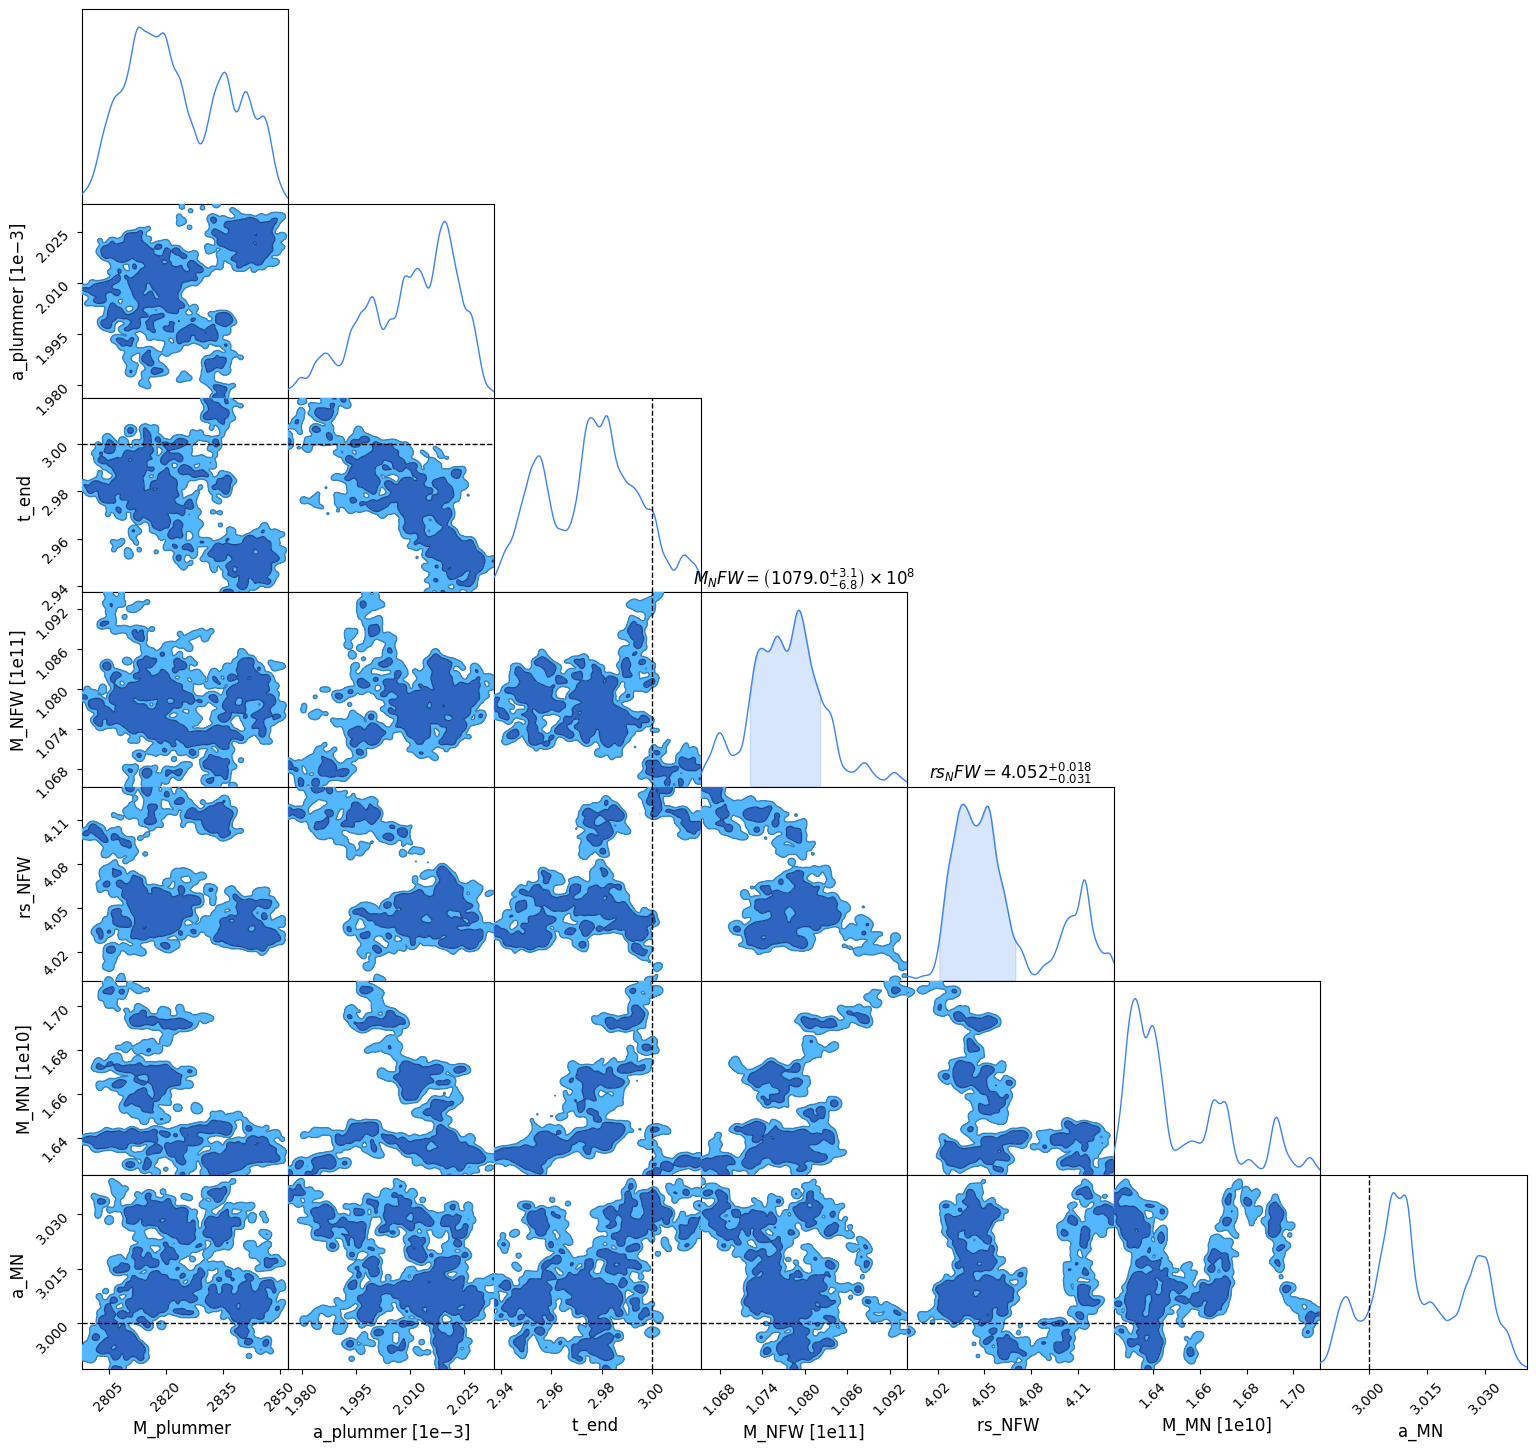

In [23]:
from chainconsumer import Chain, ChainConsumer, Truth
import pandas as pd

df = pd.DataFrame(out_samps, columns=['M_plummer', 'a_plummer', 't_end', 'M_NFW', 'rs_NFW', 'M_MN', 'a_MN'])
df['M_plummer'] = 10**df['M_plummer'] * code_units.code_mass.to(u.Msun)
df['a_plummer'] = 10**df['a_plummer'] * code_units.code_length.to(u.kpc)
df['t_end'] = 10**df['t_end'] * code_units.code_time.to(u.Gyr)
df['M_NFW'] = 10**df['M_NFW'] * code_units.code_mass.to(u.Msun) 
df['rs_NFW'] = 10**df['rs_NFW'] * code_units.code_length.to(u.kpc)
df['M_MN'] = 10**df['M_MN'] * code_units.code_mass.to(u.Msun)
df['a_MN'] = 10**df['a_MN'] * code_units.code_length.to(u.kpc)

df['M_plummer'] = df['M_plummer'].astype(float)
df['a_plummer'] = df['a_plummer'].astype(float)
df['t_end'] = df['t_end'].astype(float)
df['M_NFW'] = df['M_NFW'].astype(float)
df['rs_NFW'] = df['rs_NFW'].astype(float)
df['M_MN'] = df['M_MN'].astype(float)
df['a_MN'] = df['a_MN'].astype(float)
c = ChainConsumer()
c.add_chain(Chain(samples=df, name='Langevin samples'))
c.add_truth(Truth(location={'M_plummer': params.Plummer_params.Mtot * code_units.code_mass.to(u.Msun),
                            'a_plummer': params.Plummer_params.a * code_units.code_length.to(u.kpc),
                            't_end': params.t_end * code_units.code_time.to(u.Gyr),
                            'M_NFW': params.NFW_params.Mvir * code_units.code_mass.to(u.Msun),
                            'rs_NFW': params.NFW_params.r_s * code_units.code_length.to(u.kpc),
                            'M_MN': params.MN_params.M * code_units.code_mass.to(u.Msun),
                            'a_MN': params.MN_params.a * code_units.code_length.to(u.kpc)}), )
fig = c.plotter.plot()